In [1]:
import matplotlib
import os
os.chdir('../sim')

In [2]:
# !nrnivmodl -coreneuron mod/
# !nrnivmodl mod/

In [3]:
"""
cfg.py 

Simulation configuration for S1 model (using NetPyNE)
This file has sim configs as well as specification for parameterized values in netParams.py 

Contributors: salvadordura@gmail.com, fernandodasilvaborges@gmail.com
"""

from netpyne import specs, sim
import pickle, json
import numpy as np
import pandas as pd

%matplotlib inline

cfg = specs.SimConfig()  

#------------------------------------------------------------------------------
#
# SIMULATION CONFIGURATION
#
#------------------------------------------------------------------------------

cfg.simType='run_subNets'
cfg.coreneuron = False

#------------------------------------------------------------------------------
# Run parameters
#------------------------------------------------------------------------------
cfg.duration = 1.0*1e0 ## Duration of the sim, in ms  
cfg.dt = 0.025
cfg.seeds = {'cell': 4321, 'conn': 4321, 'stim': 4321, 'loc': 4321} 
cfg.hParams = {'celsius': 34, 'v_init': -71}  
cfg.verbose = False
cfg.createNEURONObj = True
cfg.createPyStruct = True  
cfg.cvode_active = False
cfg.cvode_atol = 1e-6
cfg.cache_efficient = True
cfg.printRunTime = 0.1

cfg.includeParamsLabel = False
cfg.printPopAvgRates = True

cfg.checkErrors = True

# S1 pop
cfg.poptypeNumber = 55 # m-types
cfg.celltypeNumber = 207 # me-types

cfg.rootFolder = os.getcwd()

In [4]:
#------------------------------------------------------------------------------  
# S1 Cells
# Load 55 Morphological Names and Cell pop numbers -> L1:6 L23:10 L4:12 L5:13 L6:14
# Load 207 Morpho-electrical Names used to import the cells from 'cell_data/' -> L1:14 L23:43 L4:46 L5:52 L6:52
# Create [Morphological,Electrical] = number of cell metype in the sub-pop

with open('cells/S1-cells-distributions-Human.txt') as mtype_file:
    mtype_content = mtype_file.read()       

cfg.popNumber = {}
cfg.cellNumber = {} 
cfg.popLabel = {} 
popParam = []
cellParam = []
cfg.meParamLabels = {} 
cfg.popLabelEl = {} 
cfg.cellLabel = {}

for line in mtype_content.split('\n')[:-1]:
    cellname, mtype, etype, n, m = line.split()
    metype = mtype + '_' + etype[0:3]
    cfg.cellNumber[metype] = int(n)
    cfg.popLabel[metype] = mtype
    cfg.popNumber[mtype] = int(m)
    cfg.cellLabel[metype] = cellname[0:-3]

    if mtype not in popParam:
        popParam.append(mtype)
        cfg.popLabelEl[mtype] = [] 
               
    cfg.popLabelEl[mtype].append(metype)
    
    cellParam.append(mtype + '_' + etype[0:3])

    # print(cellname, mtype, etype, n, m)
    
cfg.S1pops = popParam
cfg.S1cells = cellParam

cfg.popParamLabels = popParam
cfg.cellParamLabels = cellParam


In [5]:
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']

cfg.Ecells = [] 
cfg.h01_mtype = {}

for metype in cfg.S1cells: # metype    

    mtype = cfg.popLabel[metype]

    if mtype[1] == '2':
        layer = 'L23'      
    else:
        layer = mtype[0:2]         

    if mtype in Epops:  
        cfg.h01_mtype[layer+'E'] = 0
        cfg.Ecells.append(metype)      
    else:
        cfg.h01_mtype[layer+'I'] = 0
        
for metype in cfg.S1cells: # metype    

    mtype = cfg.popLabel[metype]

    if mtype[1] == '2':
        layer = 'L23'      
    else:
        layer = mtype[0:2]         

    if mtype in Epops:  
        cfg.h01_mtype[layer+'E'] = cfg.h01_mtype[layer+'E'] + cfg.cellNumber[metype]
    else:
        cfg.h01_mtype[layer+'I'] = cfg.h01_mtype[layer+'I'] + cfg.cellNumber[metype]
        

In [6]:
nodes_new = pd.read_csv('../data/cell_positions_h01_rotated.csv')

In [28]:
cfg.cylinderRadius_h01 = 300.0 # 6796 cells for cfg.cylinderRadius_h01 = 366.32

nodes_new[nodes_new['distance2Dcenter'] < cfg.cylinderRadius_h01]

,Unnamed: 0,id,x,y,z,x_new,y_new,z_new,distance2Dcenter,layer,EI,mtype,info
0,0,3195297945,2079128,1323232,42240,908.725307,1690.221158,42.240,195.850263,4,excitatory,L4E,L4pyramidalneuron
1,1,4519199338,2090464,1369448,30720,950.479935,1667.396290,30.720,158.839424,4,excitatory,L4E,L4pyramidalneuron
2,2,4475878153,2054304,1372584,42240,928.390581,1638.596281,42.240,176.694964,5,excitatory,L5E,L5pyramidalneuron
3,3,3253775599,2037400,1313760,38400,873.574406,1665.821181,38.400,231.036450,4,excitatory,L4E,L4pyramidalneuron
4,4,3719255305,2066464,1284832,46080,871.842116,1706.791224,46.080,231.341425,4,excitatory,L4E,L4pyramidalneuron
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15529,15529,101966872869,2422208,1413760,169620,1207.065134,1882.295500,169.620,136.886212,4,inhibitory,L4I,layer-unclassifiedneuroninterneuron
15535,15535,102200007236,2476128,1468416,172524,1283.786812,1885.198750,172.524,203.853622,4,excitatory,L4E,layer-unclassifiedneuronunclassified-neuron
15536,15536,102228727723,2365984,1486336,169455,1222.677027,1791.826263,169.455,149.319876,4,excitatory,L4E,layer-unclassifiedneuronunclassified-neuronthi...
15565,15565,105268101673,1651712,2204224,172029,1270.384244,780.257337,172.029,191.630967,7,excitatory,L6E,layer-unclassifiedneuronunclassified-neuron


In [29]:
h01type, h01Number = np.unique(nodes_new[nodes_new['distance2Dcenter'] < cfg.cylinderRadius_h01]['mtype'].values, return_counts=True)
h01type, h01Number

(array(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I'],
       dtype=object),
 array([ 244, 1618,  898,  948,  240,  693,  213,  610,  101]))

In [30]:
cfg.h01_ratio_number = {}
cfg.List_h01 = {}
print('layer','\t','h01','\t','S1','\t', "perc\n")
for h01N, h01t in enumerate(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']):
    cfg.h01_ratio_number[h01t] = h01Number[h01N]/cfg.h01_mtype[h01t]
    print(h01t,'\t',h01Number[h01N],'\t',cfg.h01_mtype[h01t],'\t',"%.2f" % (100.0*cfg.h01_ratio_number[h01t]))
    cfg.List_h01[h01t] = []

for mtype in cfg.S1pops:

    if mtype[1] == '2':
        layer = 'L23'      
    else:
        layer = mtype[0:2]         

    if mtype in Epops:    
        h01t = layer+'E'
    else:
        h01t = layer+'I'    

    cfg.List_h01[h01t].append(mtype)

# cfg.List_h01

layer 	 h01 	 S1 	 perc

L1I 	 244 	 338 	 72.19
L23E 	 1618 	 5877 	 27.53
L23I 	 898 	 1647 	 54.52
L4E 	 948 	 4178 	 22.69
L4I 	 240 	 478 	 50.21
L5E 	 693 	 5050 	 13.72
L5I 	 213 	 1064 	 20.02
L6E 	 610 	 11462 	 5.32
L6I 	 101 	 1252 	 8.07


In [31]:
cfg.popNumber_new = {}
number=0
listnew = []

for h01N, h01t in enumerate(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']):
# for h01t in cfg.List_h01.keys():
    number=0
    print()

    for mtype in cfg.List_h01[h01t]:

        if mtype[1] == '2':
            layer = 'L23'      
        else:
            layer = mtype[0:2]         


        cfg.popNumber_new[mtype] = int(0.5 + cfg.popNumber[mtype] * cfg.h01_ratio_number[h01t]) 
        
        number+=cfg.popNumber_new[mtype]

        print(mtype, cfg.popNumber[mtype], cfg.popNumber_new[mtype], h01Number[h01N], number)
        
    cfg.popNumber_new[mtype] = cfg.popNumber_new[mtype] + h01Number[h01N] - number
    number+= h01Number[h01N] - number

    print(" ",mtype, cfg.popNumber[mtype], cfg.popNumber_new[mtype], h01Number[h01N], number)
        



L1_DAC 58 42 244 42
L1_DLAC 24 17 244 59
L1_HAC 91 66 244 125
L1_NGC-DA 72 52 244 177
L1_NGC-SA 52 38 244 215
L1_SLAC 41 30 244 245
  L1_SLAC 41 29 244 244

L23_PC 5877 1618 1618 1618
  L23_PC 5877 1618 1618 1618

L23_BP 28 15 898 15
L23_BTC 104 57 898 72
L23_DBC 175 95 898 167
L23_LBC 456 249 898 416
L23_MC 333 182 898 598
L23_NBC 268 146 898 744
L23_SBC 166 91 898 835
L23_ChC 61 33 898 868
L23_NGC 56 31 898 899
  L23_NGC 56 30 898 898

L4_PC 2674 607 948 607
L4_SP 1098 249 948 856
L4_SS 406 92 948 948
  L4_SS 406 92 948 948

L4_BP 8 4 240 4
L4_BTC 20 10 240 14
L4_DBC 40 20 240 34
L4_LBC 122 61 240 95
L4_ChC 8 4 240 99
L4_MC 118 59 240 158
L4_NBC 96 48 240 206
L4_NGC 6 3 240 209
L4_SBC 60 30 240 239
  L4_SBC 60 31 240 240

L5_STPC 302 41 693 41
L5_TTPC1 2403 330 693 371
L5_TTPC2 2003 275 693 646
L5_UTPC 342 47 693 693
  L5_UTPC 342 47 693 693

L5_BP 34 7 213 7
L5_BTC 76 15 213 22
L5_DBC 96 19 213 41
L5_NBC 201 40 213 81
L5_NGC 8 2 213 83
L5_SBC 25 5 213 88
L5_ChC 19 4 213 92
L5_LBC 2

<BarContainer object of 9 artists>

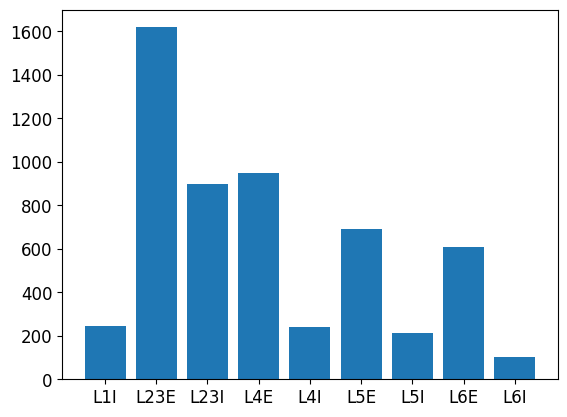

In [84]:
import matplotlib.pyplot as plt
plt.bar(h01type, h01Number)

In [99]:
len(Ipops)

42

<BarContainer object of 15 artists>

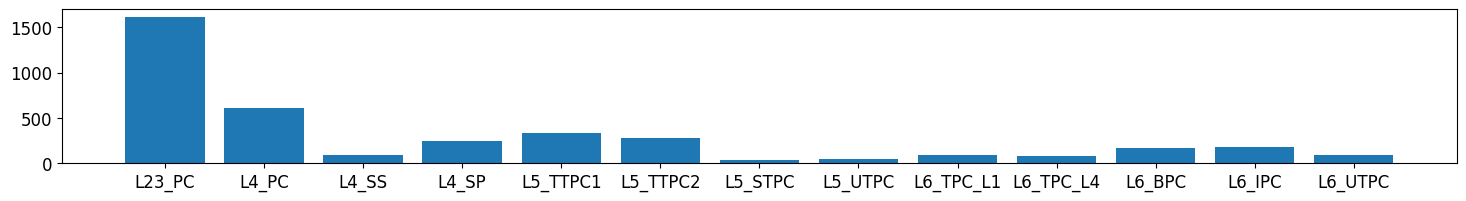

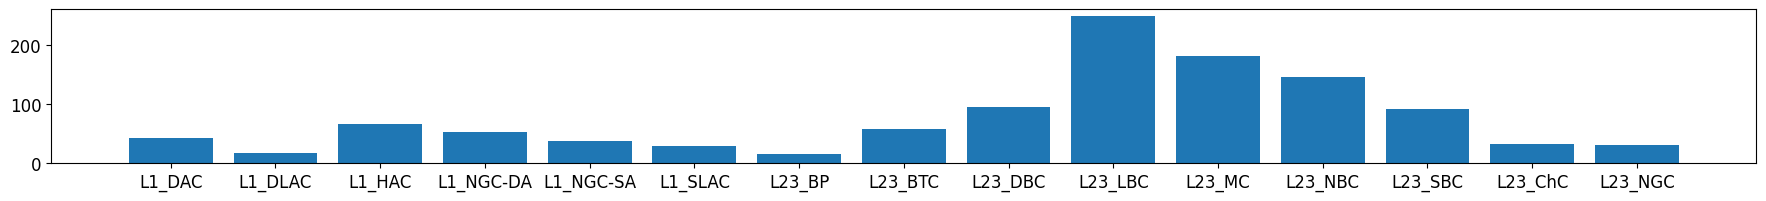

In [105]:
fig =plt.figure(figsize=(18,2))
plt.bar(Epops, [cfg.popNumber_new[pop] for pop in Epops])
fig =plt.figure(figsize=(22,2))
plt.bar(Ipops[0:15], [cfg.popNumber_new[pop] for pop in Ipops[0:15]])
# fig =plt.figure(figsize=(24,2))
# plt.bar(Ipops[21:42], [cfg.popNumber_new[pop] for pop in Ipops[21:42]])

In [32]:
cfg.cellNumber_new = {}

for mtype in cfg.S1pops:
    print()
    number=0
    for cellEl in range(min(np.size(cfg.popLabelEl[mtype]),cfg.popNumber_new[mtype])):

        metype = cfg.popLabelEl[mtype][cellEl]

        if cfg.popNumber_new[mtype] <= np.size(cfg.popLabelEl[mtype]):
            cfg.cellNumber_new[metype] = int(1.0)
        else:
            cfg.cellNumber_new[metype] = int(0.5 + cfg.cellNumber[metype]*cfg.popNumber_new[mtype]/cfg.popNumber[mtype])

        number+=cfg.cellNumber_new[metype]

        print(int(number), metype, cfg.cellNumber[metype], mtype, cfg.popNumber_new[mtype],cfg.cellNumber_new[metype])

    cfg.cellNumber_new[metype] = cfg.cellNumber_new[metype] + cfg.popNumber_new[mtype] - number
    print(" ", int(number), metype, cfg.cellNumber[metype], mtype, cfg.popNumber_new[mtype],cfg.cellNumber_new[metype])


    if cfg.cellNumber_new[metype] == 0:

        if  cfg.cellNumber_new['L6_DBC_cAC'] == 2 and cfg.cellNumber_new['L6_DBC_cNA'] == 0:
            print(" ########### \n fixing cellNumber_new = 0 for L6_DBC_cNA")
            cfg.cellNumber_new['L6_DBC_cAC'] = 1
            cfg.cellNumber_new['L6_DBC_cNA'] = 1
            print(" ", int(number), metype, cfg.cellNumber[metype], mtype, cfg.popNumber_new[mtype],cfg.cellNumber_new[metype])

        if cfg.cellNumber_new[metype] == 0:
            print("fix this like above")
            break




42 L1_DAC_cNA 58 L1_DAC 42 42
  42 L1_DAC_cNA 58 L1_DAC 42 42

17 L1_DLAC_cNA 24 L1_DLAC 17 17
  17 L1_DLAC_cNA 24 L1_DLAC 17 17

15 L1_HAC_bNA 21 L1_HAC 66 15
66 L1_HAC_cNA 70 L1_HAC 66 51
  66 L1_HAC_cNA 70 L1_HAC 66 51

7 L1_NGC-DA_bNA 9 L1_NGC-DA 52 7
14 L1_NGC-DA_cAC 9 L1_NGC-DA 52 7
53 L1_NGC-DA_cNA 54 L1_NGC-DA 52 39
  53 L1_NGC-DA_cNA 54 L1_NGC-DA 52 38

38 L1_NGC-SA_cNA 52 L1_NGC-SA 38 38
  38 L1_NGC-SA_cNA 52 L1_NGC-SA 38 38

10 L1_SLAC_bNA 14 L1_SLAC 29 10
16 L1_SLAC_cAC 8 L1_SLAC 29 6
29 L1_SLAC_cNA 19 L1_SLAC 29 13
  29 L1_SLAC_cNA 19 L1_SLAC 29 13

2 L23_BP_bAC 4 L23_BP 15 2
7 L23_BP_bNA 9 L23_BP 15 5
12 L23_BP_cAC 9 L23_BP 15 5
15 L23_BP_cNA 6 L23_BP 15 3
  15 L23_BP_cNA 6 L23_BP 15 3

9 L23_BTC_bAC 16 L23_BTC 57 9
23 L23_BTC_bNA 25 L23_BTC 57 14
47 L23_BTC_cAC 44 L23_BTC 57 24
57 L23_BTC_cNA 19 L23_BTC 57 10
  57 L23_BTC_cNA 19 L23_BTC 57 10

8 L23_DBC_bAC 15 L23_DBC 95 8
55 L23_DBC_bNA 86 L23_DBC 95 47
95 L23_DBC_cAC 74 L23_DBC 95 40
  95 L23_DBC_cAC 74 L23_DBC 95 40


In [33]:
number=0
for mtype in cfg.S1pops:
    for cellEl in range(np.size(cfg.popLabelEl[mtype])):

        metype = cfg.popLabelEl[mtype][cellEl]

        try:
            number+=cfg.cellNumber_new[metype]
        except:
            print(metype, "not inclued for this size")

print(number)


cfg.popLabelEl = {} 
for metype in cfg.cellNumber_new.keys():

    mtype = cfg.popLabel[metype] 

    if mtype not in cfg.popLabelEl.keys():
        cfg.popLabelEl[mtype] = [] 
               
    cfg.popLabelEl[mtype].append(metype)
    

number=0
for mtype in cfg.S1pops:
    for cellEl in range(np.size(cfg.popLabelEl[mtype])):

        metype = cfg.popLabelEl[mtype][cellEl]

        try:
            number+=cfg.cellNumber_new[metype]
        except:
            print(metype, "not inclued for this size")

print(number)


L5_NGC_cNA not inclued for this size
L6_DBC_cNA not inclued for this size
L6_NGC_cAC not inclued for this size
L6_NGC_cNA not inclued for this size
L6_ChC_dNA not inclued for this size
5565
5565


In [34]:
#------------------------------------------------------------------------------
# Cells
#------------------------------------------------------------------------------
# TO DEBUG - import and simulate only the Cell soma (to study only the Net)
cfg.reducedtest = True    

# TO DEBUG - Create only 5 Cells for each MEtype in S1
cfg.oneCellperMEtypeS1 = False 

In [35]:
#------------------------------------------------------------------------------  
# TO DEBUG - Create only one Cell per MEtype in S1 cells
if cfg.oneCellperMEtypeS1:
	cfg.popNumber = {}
	cfg.cellNumber = {} 
	for mtype in cfg.S1pops:
		cfg.popNumber[mtype] = 0

	for line in mtype_content.split('\n')[:-1]:
		cellname, mtype, etype, n, m = line.split()
		metype = mtype + '_' + etype[0:3]
		if int(n) < 5:
			cfg.cellNumber[metype] = int(n)
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + int(n)
		else:
			cfg.cellNumber[metype] = 5
			cfg.popNumber[mtype] = cfg.popNumber[mtype] + 5


In [36]:
len(cfg.cellNumber_new.keys()), len(cfg.popNumber_new.keys())

(129, 55)

In [37]:
cfg.S1pops = list(cfg.popNumber_new.keys())
cfg.S1cells = list(cfg.cellNumber_new.keys())

cfg.popParamLabels = list(cfg.popNumber_new.keys())
cfg.cellParamLabels = list(cfg.cellNumber_new.keys())

## Run only selected populations (me-types)

In [38]:
# subPopLabels = ['L1_DAC','L1_DLAC',#'L1_HAC','L1_NGC_DA','L1_NGC_SA','L1_SLAC',
#  'L23_PC','L23_MC','L23_SBC', #'L23_BP','L23_BTC','L23_ChC','L23_DBC','L23_LBC','L23_NBC','L23_NGC',
#  'L4_PC','L4_SBC','L4_MC', # 'L4_BP','L4_BTC','L4_ChC','L4_DBC','L4_LBC','L4_NBC','L4_NGC','L4_SP','L4_SS',
#  'L5_TTPC2','L5_SBC','L5_MC', #'L5_BP','L5_BTC','L5_ChC','L5_DBC','L5_LBC','L5_NBC','L5_NGC','L5_STPC','L5_TTPC1','L5_UTPC',
#  'L6_TPC_L4','L6_SBC','L6_MC'] #,'L6_BPC','L6_BP','L6_BTC','L6_ChC','L6_DBC','L6_IPC','L6_LBC','L6_NBC','L6_NGC','L6_TPC_L1','L6_UTPC']

# INH
# PV, SST, VIP

# subPopLabels = ['L1_HAC','L23_MC','L4_SP', 'L5_TTPC2','L6_LBC']


In [39]:
# subPopLabels = cfg.S1pops#[36:38] # from 0 to 55 is full S1 -> L1:6 L23:10 L4:12 L5:13 L6:14
#------------------------------------------------------------------------------  
# subPopLabels = cfg.S1pops
# cfg.S1pops = subPopLabels
# cfg.S1cells = []
# for metype in cfg.cellParamLabels:
#     if cfg.popLabel[metype] in subPopLabels:        
#         cfg.S1cells.append(metype)
        
cfg.thalamicpops = []

# cfg.popParamLabels = cfg.S1pops
# cfg.cellParamLabels = cfg.S1cells

# cfg.cellNumber[metype]
# cfg.popNumber[cfg.popLabel[metype]]
#------------------------------------------------------------------------------  
# for metype in cfg.cellParamLabels:
#     print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   
    
#------------------------------------------------------------------------------  
## Change popNumber
#------------------------------------------------------------------------------  
# cfg.cellNumber[metype] = 25
# cfg.popNumber[cfg.popLabel[metype]] = 25
# #------------------------------------------------------------------------------  
# for metype in cfg.cellParamLabels:
#     print(metype,cfg.cellNumber[metype],cfg.popLabel[metype],cfg.popNumber[cfg.popLabel[metype]])   

In [40]:
#--------------------------------------------------------------------------
# Recording 
#--------------------------------------------------------------------------
cfg.allpops = cfg.cellParamLabels
cfg.cellsrec = 1
if cfg.cellsrec == 0:  cfg.recordCells = cfg.allpops # record all cells
elif cfg.cellsrec == 1: cfg.recordCells = [(pop,0) for pop in cfg.allpops] # record one cell of each pop
elif cfg.cellsrec == 2: # record one cell of each cellMEtype
    cfg.recordCells = []
    for metype in cfg.cellParamLabels:
        if cfg.cellNumber[metype] < 5:
            for numberME in range(cfg.cellNumber[metype]):
                cfg.recordCells.append((metype,numberME))
        else:
            numberME = 0
            diference = cfg.cellNumber[metype] - 5.0*int(cfg.cellNumber[metype]/5.0)
            
            for number in range(5):            
                cfg.recordCells.append((metype,numberME))
                
                if number < diference:              
                    numberME+=int(np.ceil(cfg.cellNumber[metype]/5.0))  
                else:
                    numberME+=int(cfg.cellNumber[metype]/5.0)
                
        
cfg.recordTraces = {'V_soma': {'sec':'soma_0', 'loc':0.5, 'var':'v'}}  ## Dict with traces to record
cfg.recordStim = False
cfg.recordTime = False
cfg.recordStep = 0.1    

In [41]:
#------------------------------------------------------------------------------
# Saving
#------------------------------------------------------------------------------
cfg.simLabel = 'subNet_1'
cfg.saveFolder = '../runSubNets/'+cfg.simLabel
cfg.savePickle = False         	## Save pkl file
cfg.saveJson = False	           	## Save json file
cfg.saveDataInclude = ['simData'] ## , 'netParams', 'simConfig', ,'simData'
cfg.backupCfgFile = None
cfg.gatherOnlySimData = False
cfg.saveCellSecs = False
cfg.saveCellConns = True

In [42]:
"""
netParams.py
"""
# Rat data
# Layer	height (um)	height (norma)	from	to
# L1	165		    0.079		    0.000	0.079
# L2	149		    0.072		    0.079	0.151
# L3	353		    0.170		    0.151	0.320
# L4	190		    0.091		    0.320	0.412
# L5	525		    0.252		    0.412	0.664
# L6	700		    0.336		    0.664	1.000
# L23	502		    0.241		    0.079	0.320
# All	2082	    1.000	

# L23 Human net
# #              L2/3   L4     L5
# PYRmaxApics = [550   ,1550   ,1900]
# uppers =      [-250  ,-1200 ,-1600]
# lowers =      [-1200 ,-1580 ,-2300]


# Network parameters
netParams = specs.NetParams()  # object of class NetParams to store the network parameters

soma_area_scaling_factor = 2.453
axon_diameter_scaling_factor = 2.453
main_axon_diameter_scaling_factor = 1
apic_diameter_scaling_factor = 1.876
dend_diameter_scaling_factor = 1.946
dend_length_scaling_factor = 1.17

cfg.sizeY = 2557.76
cfg.sizeX = 600.0
cfg.sizeZ = 600.0

netParams.scale = 1.0 # Scale factor for number of cells
netParams.sizeX = cfg.sizeX # x-dimension (horizontal length) size in um
netParams.sizeY = cfg.sizeY# y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = cfg.sizeZ # z-dimension (horizontal depth) size in um
netParams.shape = 'cylinder' # cylindrical (column-like) volume


layer = {'1':[0.0, 0.18993098680007983], '2': [0.18993098680007983,0.3192496317490944], '3': [0.3192496317490944,0.4957762252719994], 
        '23': [0.18993098680007983,0.4957762252719994], '4':[0.4957762252719994,0.6168365917126917], '5': [0.6168365917126917,0.8034503279463661], 
        '6': [0.8034503279463661,1.0], 'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries

nodesinfo = nodes_new[nodes_new['distance2Dcenter'] < cfg.cylinderRadius_h01]

print(np.unique(nodesinfo['layer'].values, return_counts=True) , np.unique(nodesinfo['mtype'].values, return_counts=True) , [(3241.1252045639344 - max(nodesinfo[nodesinfo['layer']==ii]['y_new'].values))/(3241.1252045639344-683.3650175664178) for ii in [1,2,3,4,5,6]])
print(max(nodesinfo[nodesinfo['layer']==1]['y_new'].values), min(nodesinfo[nodesinfo['layer']==6]['y_new'].values), max(nodesinfo[nodesinfo['layer']==1]['y_new'].values)-  min(nodesinfo[nodesinfo['layer']==6]['y_new'].values))

(array([1, 2, 3, 4, 5, 6, 7]), array([ 244, 1616,  900, 1188,  906,  446,  265])) (array(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I'],
      dtype=object), array([ 244, 1618,  898,  948,  240,  693,  213,  610,  101])) [0.01571504771102972, 0.18993098680007983, 0.3192496317490944, 0.4957762252719994, 0.6168365917126917, 0.8034503279463661]
3200.929881191896 855.5144033376403 2345.415477854256


In [43]:
#------------------------------------------------------------------------------
# General network parameters
#------------------------------------------------------------------------------

cellModels = ['HH_full']
Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']
Ipops = []
for popName in cfg.S1pops:
    if popName not in Epops:
        Ipops.append(popName)

Epops = []
for popName in cfg.S1pops:
    if popName not in Ipops:
        Epops.append(popName)   

In [44]:
#------------------------------------------------------------------------------
# General connectivity parameters
#------------------------------------------------------------------------------
netParams.defaultThreshold = -10.0 # spike threshold, 10 mV is NetCon default, lower it for all cells
netParams.defaultDelay = 0.1 # default conn delay (ms)
netParams.propVelocity = 300.0 #  300 μm/ms (Stuart et al., 1997)
netParams.scaleConnWeightNetStims = 0.001  # weight conversion factor (from nS to uS)

In [45]:
number=0
cfg.pyr_positions = {}

for h01N, h01t in enumerate(['L1I', 'L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']):

    listPositions = list(nodesinfo[nodesinfo['mtype']==h01t].index)
    np.random.seed(0)
    shuffled_array = np.random.permutation(listPositions)
    
    gid1 = 0

    for mtype in cfg.List_h01[h01t]:

        if mtype[1] == '2':
            layer = 'L23'      
        else:
            layer = mtype[0:2]         

        for cellEl in range(np.size(cfg.popLabelEl[mtype])):

            metype = cfg.popLabelEl[mtype][cellEl]

            try:
                gid2 = gid1 + cfg.cellNumber_new[metype]
                cfg.pyr_positions[metype] = [[float(nodesinfo['x_new'][gid]) , float(nodesinfo['y_new'][gid]) , float(nodesinfo['z_new'][gid])] for gid in shuffled_array[gid1:gid2]]
                gid1 = gid1 + cfg.cellNumber_new[metype]
            except:            
                cfg.pyr_positions[metype] = []

            number+=len(cfg.pyr_positions[metype])
            # print(metype,len(cfg.pyr_positions[metype]))
print(number)


5565


In [46]:
# len(pyr_positions), len(cfg.S1cells)
# # cellsList not working with 'diversity': True yet!!!
# for cellName in cfg.S1cells:  
#     cellsList = [{'x': x, 'y': y, 'z': z} for x,y,z in pyr_positions[cellName]]  
#     netParams.popParams[cellName] = {'cellType': cellName, 'cellsList': cellsList, 'cellModel': 'HH_full', 'diversity': True}

In [47]:
# ------------------------------------------------------------------------------
# Population parameters
# ------------------------------------------------------------------------------
# S1
cfg.scaleDensity = 1.0

layer = {'1':[0.0, 0.17431214670060], '2': [0.17431214670060,0.3037022055398974], '3': [0.3037022055398974,0.48032628269160704], 
        '23': [0.17431214670060,0.48032628269160704], '4':[0.48032628269160704,0.6014535025371577], '5': [0.6014535025371577,0.7881702928423451], 
        '6': [0.7881702928423451,1.0], 'longS1': [2.2,2.3], 'longS2': [2.3,2.4]}  # normalized layer boundaries


for cellName in cfg.S1cells:
	layernumber = cellName[1:2]
	if layernumber == '2':
		netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer['23'], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber_new[cellName])), 'diversity': True}
	else:
		netParams.popParams[cellName] = {'cellType': cellName, 'cellModel': 'HH_full', 'ynormRange': layer[layernumber], 
                                        'numCells': int(np.ceil(cfg.scaleDensity*cfg.cellNumber_new[cellName])), 'diversity': True}

In [48]:
netParams.popParams[cellName]

{'cellType': 'L6_NBC_cNA',
 'cellModel': 'HH_full',
 'ynormRange': [0.7881702928423451, 1.0],
 'numCells': 7,
 'diversity': True}

In [49]:
#------------------------------------------------------------------------------
# Cell parameters  # L1 70  L23 215  L4 230 L5 260  L6 260  = 1035
#------------------------------------------------------------------------------
## S1 cell property rules

smaller_number_of_axon_sections = {'L1_DAC_bNA': 2, 'L1_DAC_cNA': 1, 'L1_DLAC_cNA': 4, 'L1_HAC_bNA': 3, 'L1_HAC_cIR': 5, 'L1_HAC_cNA': 4, 'L1_NGC-DA_bNA': 3, 
                                   'L1_NGC-DA_cAC': 3, 'L1_NGC-DA_cNA': 5, 'L1_NGC-DA_cST': 3, 'L1_NGC-SA_cNA': 4, 'L1_SLAC_bNA': 4, 'L1_SLAC_cAC': 1, 'L1_SLAC_cNA': 1, 
                                   'L23_BP_bAC': 1, 'L23_BP_bIR': 1, 'L23_BP_bNA': 2, 'L23_BP_cAC': 3, 'L23_BP_cNA': 2, 'L23_BP_dST': 1, 'L23_BTC_bAC': 5, 'L23_BTC_bIR': 5, 
                                   'L23_BTC_bNA': 5, 'L23_BTC_cAC': 5, 'L23_BTC_cNA': 5, 'L23_ChC_cAC': 4, 'L23_ChC_cNA': 3, 'L23_ChC_dNA': 3, 'L23_DBC_bAC': 1, 
                                   'L23_DBC_bIR': 1, 'L23_DBC_bNA': 5, 'L23_DBC_cAC': 5, 'L23_LBC_bAC': 3, 'L23_LBC_bNA': 3, 'L23_LBC_cAC': 3, 'L23_LBC_cNA': 4, 
                                   'L23_LBC_cST': 3, 'L23_LBC_dNA': 3, 'L23_MC_bAC': 4, 'L23_MC_bNA': 4, 'L23_MC_cAC': 1, 'L23_MC_cNA': 2, 'L23_MC_dNA': 2, 'L23_NBC_bAC': 5, 
                                   'L23_NBC_bNA': 1, 'L23_NBC_cAC': 4, 'L23_NBC_cIR': 5, 'L23_NBC_cNA': 1, 'L23_NBC_dNA': 1, 'L23_NGC_bNA': 2, 'L23_NGC_cAC': 2, 'L23_NGC_cNA': 2, 
                                   'L23_NGC_cST': 2, 'L23_PC_cAD': 5, 'L23_SBC_bNA': 3, 'L23_SBC_cAC': 3, 'L23_SBC_dNA': 3, 'L4_BP_bAC': 1, 'L4_BP_bIR': 1, 'L4_BP_bNA': 1, 
                                   'L4_BP_cAC': 2, 'L4_BP_cNA': 1, 'L4_BP_dST': 1, 'L4_BTC_bAC': 2, 'L4_BTC_bIR': 2, 'L4_BTC_bST': 2, 'L4_BTC_cAC': 4, 'L4_BTC_cNA': 2, 
                                   'L4_BTC_dNA': 2, 'L4_ChC_cAC': 1, 'L4_ChC_cNA': 1, 'L4_ChC_dNA': 1, 'L4_DBC_bAC': 1, 'L4_DBC_bIR': 5, 'L4_DBC_bNA': 1, 'L4_DBC_bST': 1, 
                                   'L4_DBC_cAC': 1, 'L4_DBC_cIR': 1, 'L4_DBC_cNA': 1, 'L4_LBC_cAC': 1, 'L4_LBC_cNA': 2, 'L4_LBC_cST': 1, 'L4_LBC_dNA': 4, 'L4_LBC_dST': 1, 
                                   'L4_MC_bAC': 3, 'L4_MC_bNA': 1, 'L4_MC_cAC': 1, 'L4_MC_cNA': 4, 'L4_MC_dNA': 4, 'L4_NBC_cAC': 1, 'L4_NBC_cIR': 4, 'L4_NBC_cNA': 1, 
                                   'L4_NBC_dNA': 2, 'L4_NGC_bNA': 1, 'L4_NGC_cAC': 1, 'L4_NGC_cNA': 2, 'L4_NGC_cST': 1, 'L4_PC_cAD': 4, 'L4_SBC_bNA': 5, 'L4_SBC_cAC': 2, 
                                   'L4_SBC_dNA': 2, 'L4_SP_cAD': 2, 'L4_SS_cAD': 3, 'L5_BP_bAC': 1, 'L5_BP_bIR': 1, 'L5_BP_bNA': 1, 'L5_BP_cAC': 3, 'L5_BP_cNA': 5, 'L5_BP_dST': 3, 
                                   'L5_BTC_bAC': 1, 'L5_BTC_cAC': 1, 'L5_BTC_cNA': 1, 'L5_ChC_cAC': 1, 'L5_ChC_cNA': 1, 'L5_ChC_dNA': 1, 'L5_DBC_bAC': 2, 'L5_DBC_bIR': 2, 
                                   'L5_DBC_bNA': 2, 'L5_DBC_bST': 2, 'L5_DBC_cAC': 2, 'L5_DBC_cIR': 1, 'L5_DBC_cNA': 2, 'L5_LBC_bAC': 4, 'L5_LBC_cAC': 4, 'L5_LBC_cIR': 2, 
                                   'L5_LBC_cNA': 5, 'L5_LBC_cST': 1, 'L5_LBC_dNA': 2, 'L5_LBC_dST': 5, 'L5_MC_bAC': 4, 'L5_MC_bIR': 3, 'L5_MC_bST': 5, 'L5_MC_cAC': 5, 
                                   'L5_MC_cNA': 5, 'L5_MC_cST': 4, 'L5_MC_dNA': 4, 'L5_NBC_bAC': 1, 'L5_NBC_bIR': 1, 'L5_NBC_bST': 1, 'L5_NBC_cAC': 1, 'L5_NBC_cIR': 1, 
                                   'L5_NBC_cNA': 1, 'L5_NBC_cST': 1, 'L5_NBC_dST': 1, 'L5_NGC_bNA': 1, 'L5_NGC_cAC': 1, 'L5_NGC_cNA': 3, 'L5_NGC_cST': 1, 'L5_SBC_bNA': 5, 
                                   'L5_SBC_cAC': 1, 'L5_SBC_dNA': 3, 'L5_STPC_cAD': 4, 'L5_TTPC1_cAD': 2, 'L5_TTPC2_cAD': 2, 'L5_UTPC_cAD': 3, 'L6_BPC_cAD': 5, 'L6_BP_bAC': 1,
                                    'L6_BP_bIR': 5, 'L6_BP_bNA': 4, 'L6_BP_cAC': 2, 'L6_BP_cNA': 5, 'L6_BP_dST': 4, 'L6_BTC_bAC': 5, 'L6_BTC_cAC': 3, 'L6_BTC_cNA': 2, 
                                    'L6_ChC_cAC': 5, 'L6_ChC_cNA': 4, 'L6_ChC_dNA': 4, 'L6_DBC_bAC': 3, 'L6_DBC_bIR': 3, 'L6_DBC_bNA': 3, 'L6_DBC_bST': 3, 'L6_DBC_cAC': 3, 
                                    'L6_DBC_cIR': 2, 'L6_DBC_cNA': 3, 'L6_IPC_cAD': 1, 'L6_LBC_bAC': 5, 'L6_LBC_bIR': 4, 'L6_LBC_bNA': 4, 'L6_LBC_bST': 3, 'L6_LBC_cNA': 3, 
                                    'L6_LBC_cST': 3, 'L6_MC_bAC': 1, 'L6_MC_bIR': 2, 'L6_MC_bNA': 2, 'L6_MC_bST': 2, 'L6_MC_cAC': 2, 'L6_MC_cIR': 5, 'L6_MC_cNA': 2, 
                                    'L6_NBC_bAC': 2, 'L6_NBC_bIR': 3, 'L6_NBC_bST': 5, 'L6_NBC_cAC': 2, 'L6_NBC_cIR': 2, 'L6_NBC_cNA': 5, 'L6_NBC_cST': 2, 'L6_NBC_dST': 2, 
                                    'L6_NGC_bNA': 2, 'L6_NGC_cAC': 2, 'L6_NGC_cNA': 4, 'L6_NGC_cST': 1, 'L6_SBC_bNA': 3, 'L6_SBC_cAC': 5, 'L6_SBC_dNA': 5, 'L6_TPC_L1_cAD': 2, 
                                    'L6_TPC_L4_cAD': 3, 'L6_UTPC_cAD': 2}


In [50]:

Epops = ['L23_PC', 'L4_PC', 'L4_SS', 'L4_SP', 
             'L5_TTPC1', 'L5_TTPC2', 'L5_STPC', 'L5_UTPC',
             'L6_TPC_L1', 'L6_TPC_L4', 'L6_BPC', 'L6_IPC', 'L6_UTPC']

cfg.Ecells = [] 
for metype in cfg.S1cells: # metype      
    mtype = cfg.popLabel[metype]            
    if mtype in Epops:  
        cfg.Ecells.append(metype)      

In [51]:
cfg.scaleDensity = 1.0
cfg.reducedtest = True

for cellName in cfg.S1cells:

    print(cellName, cfg.cellNumber_new[cellName])
    
    if int(np.ceil(cfg.scaleDensity*cfg.cellNumber_new[cellName])) < 5:
        morphoNumbers = int(np.ceil(cfg.scaleDensity*cfg.cellNumber_new[cellName]))
    else:
        morphoNumbers = 5
        
    cellFraction = 1.0/morphoNumbers
    
    for morphoNumber in range(morphoNumbers):
        cellMe = cfg.cellLabel[cellName] + '_' + str(morphoNumber+1)

        if cellName in cfg.Ecells:
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cells/' + cellMe + '_cellParams.json')  
        else:
            netParams.loadCellParamsRule(label = cellMe, fileName = 'cells/' + cfg.cellLabel[cellName] + '_' + str(smaller_number_of_axon_sections[cellName]) + '_cellParams.json')  

        netParams.cellParams[cellMe]['diversityFraction'] = cellFraction        
        netParams.cellParams[cellMe]['secLists']['spiny'] = [sec for sec in netParams.cellParams[cellMe]['secLists']['all'] if sec not in netParams.cellParams[cellMe]['secLists']['axonal']]
        netParams.cellParams[cellMe]['secLists']['spinyEE'] = [sec for sec in netParams.cellParams[cellMe]['secLists']['spiny'] if sec not in netParams.cellParams[cellMe]['secLists']['somatic']]
        netParams.cellParams[cellMe]['conds']['cellType'] = cellName
        
        #-----------------------------------------------------------------------------------#
        if cfg.reducedtest:
            cellRule = {'conds': {'cellType': cellName}, 'diversityFraction': cellFraction, 'secs': {}}  # cell rule dict
            cellRule['conds'] = netParams.cellParams[cellMe]['conds']    
            cellRule['secs'] = {}
            cellRule['secs']['soma_0'] = netParams.cellParams[cellMe]['secs']['soma_0']
            cellRule['secLists'] = {}
            cellRule['secLists']['spiny'] = ['soma_0']
            cellRule['secLists']['spinyEE'] = ['soma_0']
            cellRule['secLists']['all'] = ['soma_0']
            cellRule['secLists']['basal'] = ['soma_0']   
            cellRule['secLists']['apical'] = ['soma_0']    
            netParams.cellParams[cellMe] = cellRule   # add dict to list of cell params   
            
            # print(netParams.cellParams[cellMe])
        #-----------------------------------------------------------------------------------#
   
# #------------------------------------------------------------------------------
# #  extracellular mechs
# #------------------------------------------------------------------------------

cfg.addExternalStimulation = False

if cfg.addExternalStimulation:
    for celltyp in netParams.cellParams.keys():
        for secname in netParams.cellParams[celltyp]['secs'].keys():
            netParams.cellParams[celltyp]['secs'][secname]['mechs']['extracellular'] = {}
else:
    for celltyp in netParams.cellParams.keys():
        for secname in netParams.cellParams[celltyp]['secs'].keys():
            if 'extracellular' in netParams.cellParams[celltyp]['secs'][secname]['mechs'].keys():
                # print(celltyp, secname)
                del netParams.cellParams[celltyp]['secs'][secname]['mechs']['extracellular']


L1_DAC_cNA 42
L1_DLAC_cNA 17
L1_HAC_bNA 15
L1_HAC_cNA 51
L1_NGC-DA_bNA 7
L1_NGC-DA_cAC 7
L1_NGC-DA_cNA 38
L1_NGC-SA_cNA 38
L1_SLAC_bNA 10
L1_SLAC_cAC 6
L1_SLAC_cNA 13
L23_BP_bAC 2
L23_BP_bNA 5
L23_BP_cAC 5
L23_BP_cNA 3
L23_BTC_bAC 9
L23_BTC_bNA 14
L23_BTC_cAC 24
L23_BTC_cNA 10
L23_DBC_bAC 8
L23_DBC_bNA 47
L23_DBC_cAC 40
L23_LBC_bAC 27
L23_LBC_bNA 21
L23_LBC_cNA 58
L23_LBC_dNA 143
L23_MC_bNA 5
L23_MC_cAC 152
L23_MC_cNA 19
L23_MC_dNA 6
L23_NBC_bNA 3
L23_NBC_cAC 38
L23_NBC_cNA 47
L23_NBC_dNA 58
L23_PC_cAD 1618
L23_SBC_bNA 33
L23_SBC_cAC 33
L23_SBC_dNA 25
L23_ChC_cAC 33
L23_NGC_bNA 3
L23_NGC_cAC 3
L23_NGC_cNA 24
L4_BP_bAC 1
L4_BP_bNA 2
L4_BP_cAC 1
L4_BTC_cAC 10
L4_DBC_bAC 5
L4_DBC_bNA 5
L4_DBC_cAC 5
L4_DBC_cNA 5
L4_LBC_cNA 14
L4_LBC_dNA 47
L4_PC_cAD 607
L4_SP_cAD 249
L4_SS_cAD 92
L4_ChC_cAC 3
L4_ChC_dNA 1
L4_MC_bAC 7
L4_MC_bNA 3
L4_MC_cAC 48
L4_MC_dNA 1
L4_NBC_cAC 11
L4_NBC_dNA 37
L4_NGC_bNA 1
L4_NGC_cAC 1
L4_NGC_cNA 1
L4_SBC_bNA 11
L4_SBC_cAC 11
L4_SBC_dNA 9
L5_BP_bAC 1
L5_BP_bNA 2
L5_BP_

In [52]:
# netParams.cellParams['L5_STPC_cADpyr_1']

In [53]:
#------------------------------------------------------------------------------
# load data from S1 conn pre-processing file 
#------------------------------------------------------------------------------
with open('conn/conn.pkl', 'rb') as fileObj: connData = pickle.load(fileObj)

lmat = connData['lmat']
a0mat = connData['a0mat']
d0 = connData['d0']

a0e = connData['a0mat_exp']
l0e = connData['lmat_exp']
d0e = connData['d0_exp']

a0g = connData['a0mat_gauss']
x0g = connData['x0_gauss']
l0g = connData['lmat_gauss']
d0g = connData['d0_gauss']

dfinal = connData['dfinal']
pmat = {}
pmat[12.5] = connData['pmat12um']
pmat[25] = connData['pmat25um']
pmat[50] = connData['pmat50um']
pmat[75] = connData['pmat75um']
pmat[100] = connData['pmat100um']
pmat[125] = connData['pmat125um']
pmat[150] = connData['pmat150um']
pmat[175] = connData['pmat175um']
pmat[200] = connData['pmat200um'] #max value for d0=200

synperconnNumber = connData['synperconnNumber']
connNumber = connData['connNumber']
decay = connData['decay']
gsyn = connData['gsyn']
use = connData['use']

ConnTypesNumber = connData['ConnTypesNumber'] 
ConnTypes = connData['ConnTypes']   

connIEtype = connData['connIEtype']  
connEItype = connData['connEItype']
parameters_syn = connData['parameters_syn']

In [54]:
import pandas as pd

physColumnNames = []
syntypes = []
for name,syntype in parameters_syn:    
    if name not in physColumnNames:
        physColumnNames.append(name) 
    if syntype not in syntypes:
        syntypes.append(syntype)
        
#     print(name,syntype,parameters_syn[name,syntype])
dfS6 = pd.DataFrame(index=syntypes, columns=physColumnNames)
for syntype in syntypes:
    for name in physColumnNames:    
        dfS6.loc[syntype][name] = parameters_syn[name,syntype]
dfS6

,ConnType,gsyn,gsynStd,decay,decayStd,use,useStd,dep,depStd,fac,facStd,s-types,type
0,0,0.83,0.55,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,II
3,1,0.91,0.61,10.4,6.1,0.16,0.1,45.0,21.0,376.0,253.0,I1,IE
13,2,0.75,0.32,10.4,6.1,0.415,0.212,162.0,69.0,690.0,5.0,I1,IE
1,3,0.83,0.55,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,II
4,4,0.91,0.61,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
8,5,0.75,0.32,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
9,6,0.75,0.32,8.3,2.2,0.3,0.08,1250.0,520.0,2.0,4.0,I2,IE
10,7,0.91,0.61,8.3,2.2,0.14,0.05,875.0,285.0,22.0,5.0,I2,IE
12,8,2.97,0.95,8.3,2.2,0.25,0.13,706.0,405.0,21.0,9.0,I2,IE
5,9,0.91,0.61,6.44,1.7,0.32,0.14,144.0,80.0,62.0,31.0,I3,IE


In [55]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from S1 BBP - deterministic version
#------------------------------------------------------------------------------
for syntype in syntypes:
    if syntype > 50:  # Exc
        
        netParams.synMechParams['S1_EE_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2, 
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.8, # ± 0.1 for EE -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
        netParams.synMechParams['S1_EI_STP_Det_' + str(syntype)] = {'mod': 'DetAMPANMDA',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype] 
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_AMPA': 1.74, # ± 0.18 ms
                                         'tau_r_AMPA': 0.2,
                                         'tau_r_NMDA': 0.29,
                                         'tau_d_NMDA': 43,   
                                         'NMDA_ratio': 0.4, # ± 0.1  for EI -- experimentally measured for some path?
                                         'mg':1.0, #    0.5mM where exceptionally specified?                                                                
                                            }
    else: # Inh
        
        netParams.synMechParams['S1_II_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA  ?          
                                            }
        
        netParams.synMechParams['S1_IE_STP_Det_' + str(syntype)] = {'mod': 'DetGABAAB',
                                         'Use': dfS6['use'][syntype], # ± dfS6['useStd'][syntype]
                                         'Dep': dfS6['dep'][syntype], # ± dfS6['depStd'][syntype]  
                                         'Fac': dfS6['fac'][syntype], # ± dfS6['facStd'][syntype]
                                         'tau_d_GABAA': dfS6['decay'][syntype], # ± dfS6['decayStd'][syntype]
                                         'tau_r_GABAA': 0.2,   #rng.lognormal(0.2, 0.1) in synapses.hoc  
                                         'tau_d_GABAB': 260.9,
                                         'tau_r_GABAB': 3.5,
#                                          'GABAB_ratio': 1.0,  #=0(1):The ratio of GABAB to GABAA   ?       
                                            }

In [56]:
#------------------------------------------------------------------------------
# Synaptic mechanism parameters  - mods from M1 detailed - Spont and BG
#------------------------------------------------------------------------------
## S1
netParams.synMechParams['AMPA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 1.74, 'e': 0}
netParams.synMechParams['GABAA'] = {'mod':'MyExp2SynBB', 'tau1': 0.2, 'tau2': 8.3, 'e': -80}

In [57]:
#------------------------------------------------------------------------------
# S1 Local connectivity parameters 
#------------------------------------------------------------------------------
cfg.addConn = True

cfg.synWeightFractionEE = [1.0, 1.0] # E -> E AMPA to NMDA ratio
cfg.synWeightFractionEI = [1.0, 1.0] # E -> I AMPA to NMDA ratio
cfg.synWeightFractionII = [1.0, 1.0]  # I -> I GABAA to GABAB ratio
cfg.synWeightFractionIE = [1.0, 1.0]  # I -> E GABAA to GABAB ratio
cfg.EEGain = 1.0
cfg.EIGain = 1.0
cfg.IIGain = 1.0
cfg.IEGain = 1.0

contA = 0

if cfg.addConn:    
    for pre in Ipops+Epops:
        for post in Ipops+Epops:
            if float(connNumber[pre][post]) > 0:               
                # ------------------------------------------------------------------------------    
                #  2D distance prob rules
                # ------------------------------------------------------------------------------ 
                if int(float(d0[pre][post])) < 25:    # single fit
                    if 'exp' in connData['best_fit'][pre][post]:  # exponential            
                        prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post])      
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])   
                        
                else:
                    if 'expl' in connData['best_fit'][pre][post]:  # exponential + linear interpolation [25:d0]
                        if int(float(d0[pre][post])) == 25:    #d0==25 -> exponential fit when dist_2D>25, else prob[0um:25um] = pmat[12.5]
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],float(pmat[12.5][pre][post]))
                        else:    #d0>25 -> exponential fit when dist_2D>d0, else prob[0um:d0] = linear interpolation [25:d0]
                            d01 = int(float(d0[pre][post]))
                            y1 = float(pmat[25][pre][post])
                            y2 = float(pmat[d01][pre][post])
                            x1 = 25
                            x2 = d01                   
                            angular = (y2 - y1)/(x2 - x1)
                            linear = y2 - x2*angular
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f * dist_2D + %f' % (a0mat[pre][post],lmat[pre][post],dfinal[pre][post],d0[pre][post],angular,linear)
                   
                    elif 'exp' in connData['best_fit'][pre][post]:  # exponential     
                        if float(pmat[12.5][pre][post]) > float(pmat[25][pre][post]):
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s)' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post])
                        else:  
                            prob = '%s*exp(-dist_2D/%s)*(dist_2D<%s) if dist_2D > %s else %f' % (a0e[pre][post],l0e[pre][post],dfinal[pre][post],d0e[pre][post],float(pmat[12.5][pre][post]))      
                    
                    else: # gaussian
                        prob = '%s*exp(-(dist_2D-%s)**2/(2*%s**2))*(dist_2D<%s)' % (a0g[pre][post],x0g[pre][post],l0g[pre][post],dfinal[pre][post])             
                        
                # ------------------------------------------------------------------------------    
                # I -> I
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Ipops:                             
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_II_STP_Det_' + str(connID)   
                        contA+= 1
                        netParams.connParams['II_' + pre + '_' + post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionII,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}        
                # ------------------------------------------------------------------------------
                #  I -> E  # with ME conn diversity
                # ------------------------------------------------------------------------------
                if pre in Ipops:
                    if post in Epops:                                                       
                        cellpreList_A = []
                        cellpreList_B = []
                        cellpreList_C = []
                        connID_B = -1    
                        connID_C = -1                               
                        if 'SBC' in pre or 'LBC' in pre or 'NBC' in pre:                              
                            cellpost = cfg.popLabelEl[post][0]   
                            for npre,cellpre in enumerate(cfg.popLabelEl[pre]):   
                                premtype = pre[-3:]
                                preetype = cellpre[-3:]                                    
                                connID = connIEtype[premtype][preetype]                                     
                                if connID == ConnTypes[pre][post][0]:
                                    cellpreList_A.append(cellpre)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpreList_B.append(cellpre)
                                    connID_B = ConnTypes[pre][post][1]
                                elif connID == ConnTypes[pre][post][2]:
                                    cellpreList_C.append(cellpre)
                                    connID_C = ConnTypes[pre][post][2]
                                else:
                                    print('ERROR')                                    
                        else:   
                            cellpreList_A = cfg.popLabelEl[pre]                              
                            
                        connID = ConnTypes[pre][post][0]                            
                        synMechType = 'S1_IE_STP_Det_' + str(connID)
                        
                        contA+= 1                          
                        netParams.connParams['IE_'+pre+'_'+post] = { 
                                    'preConds': {'pop': cellpreList_A}, 
                                    'postConds': {'pop': cfg.popLabelEl[post]},
                                    'synMech': synMechType,
                                    'probability': prob,
                                    'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                    'synMechWeightFactor': cfg.synWeightFractionIE,
                                    'delay': 'defaultDelay+dist_3D/propVelocity',
                                    'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                    'sec': 'spiny'}  
                

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_IE_STP_Det_' + str(connID)         
                            netParams.connParams['IE_'+pre+'_'+post+'_B'] = { 
                                        'preConds': {'pop': cellpreList_B}, 
                                        'postConds': {'pop': cfg.popLabelEl[post]},
                                        'synMech': synMechType,
                                        'probability': prob,
                                        'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionIE,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}                       
                
                                
                            if connID_C >= 0:          
                                connID = connID_C
                                synMechType = 'S1_IE_STP_Det_' + str(connID)         
                                netParams.connParams['IE_'+pre+'_'+post+'_C'] = { 
                                            'preConds': {'pop': cellpreList_C}, 
                                            'postConds': {'pop': cfg.popLabelEl[post]},
                                            'synMech': synMechType,
                                            'probability': prob,
                                            'weight': parameters_syn['gsyn',connID] * cfg.IEGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionIE,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}                       
                                
                #------------------------------------------------------------------------------   
                # E -> E
                #------------------------------------------------------------------------------
                if pre in Epops:
                    if post in Epops:    
                        connID = ConnTypes[pre][post][0]                        
                        synMechType = 'S1_EE_STP_Det_' + str(connID)   
                        contA+= 1   
                        netParams.connParams['EE_'+pre+'_'+post] = { 
                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                            'postConds': {'pop': cfg.popLabelEl[post]},
                            'synMech': synMechType,
                            'probability': prob, 
                            'weight': parameters_syn['gsyn',connID] * cfg.EEGain, 
                            'synMechWeightFactor': cfg.synWeightFractionEE,
                            'delay': 'defaultDelay+dist_3D/propVelocity',
                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                            'sec': 'spinyEE'}    
    
                #------------------------------------------------------------------------------               
                #  E -> I  with ME conn diversity
                #------------------------------------------------------------------------------   
                if pre in Epops:
                    if post in Ipops:                        
                        cellpostList_A = []
                        cellpostList_B = []
                        connID_B = -1                          
                        if ConnTypes[pre][post][0] == 131 or ConnTypes[pre][post][0] == 132: # EXCEPTIONS -> L6_IPC:L6_(DBC-LBC-NBC-SBC) and  L6_TPC_L:L6_(DBC-LBC-NBC-SBC)    
                            cellpostList_A = cfg.popLabelEl[post]     
                        elif 'LBC' in post or 'NBC' in post or 'BP' in post or 'DBC' in post or 'BTC' in post:    
                            cellpre = cfg.popLabelEl[pre][0]
                            for npost,cellpost in enumerate(cfg.popLabelEl[post]):                                
                                postmtype = post[-3:]
                                postetype = cellpost[-3:]
                                if 'BP' in postmtype:
                                    postmtype = post[-2:]       
                                connID = connEItype[postmtype][postetype]                                
                                if connID == ConnTypes[pre][post][0]:
                                    cellpostList_A.append(cellpost)    
                                elif connID == ConnTypes[pre][post][1]:
                                    cellpostList_B.append(cellpost)
                                    connID_B = ConnTypes[pre][post][1]
                                else:
                                    print('ERROR')                                
                        else:                           
                            cellpostList_A = cfg.popLabelEl[post]         
                             
                        connID = ConnTypes[pre][post][0]      
                        synMechType = 'S1_EI_STP_Det_' + str(connID)  
                        contA+= 1                                                              
                        netParams.connParams['EI_'+pre+'_'+post] = { 
                                        'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                        'postConds': {'pop': cellpostList_A},
                                        'synMech': synMechType,
                                        'probability': prob, 
                                        'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                        'synMechWeightFactor': cfg.synWeightFractionEI,
                                        'delay': 'defaultDelay+dist_3D/propVelocity',
                                        'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                        'sec': 'spiny'}   

                        if connID_B >= 0:          
                            connID = connID_B
                            synMechType = 'S1_EI_STP_Det_' + str(connID)        
                            netParams.connParams['EI_'+pre+'_'+post+'_B'] = { 
                                            'preConds': {'pop': cfg.popLabelEl[pre]}, 
                                            'postConds': {'pop': cellpostList_B},
                                            'synMech': synMechType,
                                            'probability': prob, 
                                            'weight': parameters_syn['gsyn',connID] * cfg.EIGain, 
                                            'synMechWeightFactor': cfg.synWeightFractionEI,
                                            'delay': 'defaultDelay+dist_3D/propVelocity',
                                            'synsPerConn': int(synperconnNumber[pre][post]+0.5),
                                            'sec': 'spiny'}   

In [58]:
netParams.connParams.keys()

odict_keys(['II_L1_DAC_L1_DAC', 'II_L1_DAC_L1_DLAC', 'II_L1_DAC_L1_HAC', 'II_L1_DAC_L1_NGC-DA', 'II_L1_DAC_L1_NGC-SA', 'II_L1_DAC_L1_SLAC', 'II_L1_DAC_L23_BP', 'II_L1_DAC_L23_BTC', 'II_L1_DAC_L23_DBC', 'II_L1_DAC_L23_LBC', 'II_L1_DAC_L23_MC', 'II_L1_DAC_L23_NBC', 'II_L1_DAC_L23_SBC', 'II_L1_DAC_L23_ChC', 'II_L1_DAC_L23_NGC', 'II_L1_DAC_L4_LBC', 'II_L1_DAC_L4_MC', 'II_L1_DAC_L4_NBC', 'II_L1_DAC_L4_SBC', 'II_L1_DAC_L5_DBC', 'II_L1_DAC_L5_NBC', 'II_L1_DAC_L5_MC', 'IE_L1_DAC_L23_PC', 'IE_L1_DAC_L4_PC', 'IE_L1_DAC_L4_SS', 'IE_L1_DAC_L4_SP', 'IE_L1_DAC_L5_TTPC1', 'IE_L1_DAC_L5_TTPC2', 'IE_L1_DAC_L5_STPC', 'IE_L1_DAC_L5_UTPC', 'IE_L1_DAC_L6_TPC_L1', 'IE_L1_DAC_L6_TPC_L4', 'IE_L1_DAC_L6_BPC', 'IE_L1_DAC_L6_UTPC', 'II_L1_DLAC_L1_DAC', 'II_L1_DLAC_L1_DLAC', 'II_L1_DLAC_L1_HAC', 'II_L1_DLAC_L1_NGC-DA', 'II_L1_DLAC_L1_NGC-SA', 'II_L1_DLAC_L1_SLAC', 'II_L1_DLAC_L23_BTC', 'II_L1_DLAC_L23_DBC', 'II_L1_DLAC_L23_LBC', 'II_L1_DLAC_L23_MC', 'II_L1_DLAC_L23_NBC', 'II_L1_DLAC_L23_SBC', 'II_L1_DLAC_L23_ChC'

In [59]:
netParams.connParams['EE_L5_STPC_L5_STPC']

{'preConds': {'pop': ['L5_STPC_cAD']},
 'postConds': {'pop': ['L5_STPC_cAD']},
 'synMech': 'S1_EE_STP_Det_122',
 'probability': '0.08645*exp(-(dist_2D-3.03)**2/(2*92.19**2))*(dist_2D<375)',
 'weight': 0.8,
 'synMechWeightFactor': [1.0, 1.0],
 'delay': 'defaultDelay+dist_3D/propVelocity',
 'synsPerConn': 5,
 'sec': 'spinyEE'}

In [60]:
# contA = 0
# contB = 0
# contC = 0
# for connpath in netParams.connParams.keys():
#     if '_B' in connpath[-2:]:
#         contB+=1        
# #         print()
# #         print(connpathAnt)
# #         print(netParams.connParams[connpathAnt])
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     elif '_C' in connpath[-2:]:
#         contC+=1        
# #         print(connpath)
# #         print(netParams.connParams[connpath])
#     else:        
#         contA+=1        
#     connpathAnt = connpath
# print(contA,contB,contC)
# print(contA+contB+contC)

In [61]:
#------------------------------------------------------------------------------
# Spontaneous synapses + background - data from Rat
#------------------------------------------------------------------------------
cfg.addStimSynS1 = True
cfg.rateStimE = 9.0
cfg.rateStimI = 9.0

#------------------------------------------------------------------------------
# NetStim inputs to simulate Spontaneous synapses + background in S1 neurons - data from Rat
#------------------------------------------------------------------------------
SourcesNumber = 5 # for each post Mtype - sec distribution
synperNeuronStimI = connData['synperNeuronStimI']
synperNeuronStimE = connData['synperNeuronStimE']
GsynStimI = connData['GsynStimI']
GsynStimE = connData['GsynStimE']
   
if cfg.addStimSynS1:      
    for post in Ipops + Epops:

        synperNeuron = synperNeuronStimI[post]
        ratespontaneous = cfg.rateStimI
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_INH->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}

        synperNeuron = synperNeuronStimE[post]
        ratespontaneous = cfg.rateStimE
        for qSnum in range(SourcesNumber):
            ratesdifferentiation = (0.8 + 0.4*qSnum/(SourcesNumber-1)) * (synperNeuron*ratespontaneous)/SourcesNumber
            netParams.stimSourceParams['StimSynS1_S_all_EXC->' + post + '_' + str(qSnum)] = {'type': 'NetStim', 'rate': ratesdifferentiation, 'noise': 1.0}
            
    #------------------------------------------------------------------------------
    for post in Epops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'AMPA', 
                'sec': 'spinyEE', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_EXC->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_EXC->' + post + '_' + str(qSnum), 
                'synMech': 'AMPA', 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'sec': 'spiny', 
                'weight': GsynStimE[post],
                'delay': 0.1}

    for post in Epops+Ipops:
        for qSnum in range(SourcesNumber):
            netParams.stimTargetParams['StimSynS1_T_all_INH->' + post + '_' + str(qSnum)] = {
                'source': 'StimSynS1_S_all_INH->' + post + '_' + str(qSnum), 
                'conds': {'cellType': cfg.popLabelEl[post]}, 
                'synMech': 'GABAA', 
                'sec': 'spiny', 
                'weight': GsynStimI[post],
                'delay': 0.1}

In [62]:
netParams.stimTargetParams.keys()

odict_keys(['StimSynS1_T_all_EXC->L23_PC_0', 'StimSynS1_T_all_EXC->L23_PC_1', 'StimSynS1_T_all_EXC->L23_PC_2', 'StimSynS1_T_all_EXC->L23_PC_3', 'StimSynS1_T_all_EXC->L23_PC_4', 'StimSynS1_T_all_EXC->L4_PC_0', 'StimSynS1_T_all_EXC->L4_PC_1', 'StimSynS1_T_all_EXC->L4_PC_2', 'StimSynS1_T_all_EXC->L4_PC_3', 'StimSynS1_T_all_EXC->L4_PC_4', 'StimSynS1_T_all_EXC->L4_SS_0', 'StimSynS1_T_all_EXC->L4_SS_1', 'StimSynS1_T_all_EXC->L4_SS_2', 'StimSynS1_T_all_EXC->L4_SS_3', 'StimSynS1_T_all_EXC->L4_SS_4', 'StimSynS1_T_all_EXC->L4_SP_0', 'StimSynS1_T_all_EXC->L4_SP_1', 'StimSynS1_T_all_EXC->L4_SP_2', 'StimSynS1_T_all_EXC->L4_SP_3', 'StimSynS1_T_all_EXC->L4_SP_4', 'StimSynS1_T_all_EXC->L5_TTPC1_0', 'StimSynS1_T_all_EXC->L5_TTPC1_1', 'StimSynS1_T_all_EXC->L5_TTPC1_2', 'StimSynS1_T_all_EXC->L5_TTPC1_3', 'StimSynS1_T_all_EXC->L5_TTPC1_4', 'StimSynS1_T_all_EXC->L5_TTPC2_0', 'StimSynS1_T_all_EXC->L5_TTPC2_1', 'StimSynS1_T_all_EXC->L5_TTPC2_2', 'StimSynS1_T_all_EXC->L5_TTPC2_3', 'StimSynS1_T_all_EXC->L5_TTP

In [63]:
# netParams.stimTargetParams['StimSynS1_T_all_EXC->L5_STPC_4']

In [64]:
# for stimpath in netParams.stimSourceParams.keys():
#     print(stimpath)
#     print(netParams.stimSourceParams[stimpath])
#     print()    

In [65]:
# for stimpath in netParams.stimTargetParams.keys():
#     print(stimpath)
#     print(netParams.stimTargetParams[stimpath])
#     print()    

## Run small Nets in a sigle job

In [66]:
sim.initialize(
    simConfig = cfg, 	
    netParams = netParams)  				# create network object and set cfg and net params

sim.net.createPops()               			# instantiate network populations


Start time:  2024-09-24 20:54:57.889665


{L1_DAC_cNA: <netpyne.network.pop.Pop object at 0x7658cf35cc70>, L1_DLAC_cNA: <netpyne.network.pop.Pop object at 0x7658cf35cf10>, L1_HAC_bNA: <netpyne.network.pop.Pop object at 0x7658cf3654c0>, L1_HAC_cNA: <netpyne.network.pop.Pop object at 0x7658cf365160>, L1_NGC-DA_bNA: <netpyne.network.pop.Pop object at 0x7658cf365bb0>, L1_NGC-DA_cAC: <netpyne.network.pop.Pop object at 0x7658cf365a60>, L1_NGC-DA_cNA: <netpyne.network.pop.Pop object at 0x7658cf365a90>, L1_NGC-SA_cNA: <netpyne.network.pop.Pop object at 0x7658cf365f70>, L1_SLAC_bNA: <netpyne.network.pop.Pop object at 0x7658f135cc10>, L1_SLAC_cAC: <netpyne.network.pop.Pop object at 0x7658cf329160>, L1_SLAC_cNA: <netpyne.network.pop.Pop object at 0x7658cf329fd0>, L23_BP_bAC: <netpyne.network.pop.Pop object at 0x7658cf329520>, L23_BP_bNA: <netpyne.network.pop.Pop object at 0x7658cf329b20>, L23_BP_cAC: <netpyne.network.pop.Pop object at 0x7658cf3291c0>, L23_BP_cNA: <netpyne.network.pop.Pop object at 0x7658cf3295b0>, L23_BTC_bAC: <netpyne.n

In [67]:
sim.net.createCells();              			# instantiate network cells based on defined populations


Creating network of 129 cell populations on 1 hosts...
  Number of cells on node 0: 5565 
  Done; cell creation time = 8.24 s.


In [68]:
# for i,metype in enumerate(sim.net.cells):
#     ii2 = int(0.000001+(metype.tags['fraction']/(1/cfg.cellNumber_new[metype.tags['pop']])))
#     print(metype.tags['pop'],ii2,pyr_positions[metype.tags['pop']][ii2])  

#     print((3200.929881191896 - pyr_positions[metype.tags['pop']][ii2][1]))   # /(3200.929881191896-644.581391561247)

In [69]:

for i,metype in enumerate(sim.net.cells):

    if 'presyn' not in metype.tags['pop']:

        ii = int(0.000001+(metype.tags['fraction']/(1/cfg.cellNumber_new[metype.tags['pop']])))  

        metype.tags['xnorm'] = cfg.pyr_positions[metype.tags['pop']][ii][0]/cfg.sizeX
        metype.tags['ynorm'] = (3200.929881191896 - cfg.pyr_positions[metype.tags['pop']][ii][1])/cfg.sizeY
        metype.tags['znorm'] = cfg.pyr_positions[metype.tags['pop']][ii][2]/cfg.sizeZ
        metype.tags['x'] = cfg.pyr_positions[metype.tags['pop']][ii][0]
        metype.tags['y'] = 3200.929881191896 - cfg.pyr_positions[metype.tags['pop']][ii][1]
        metype.tags['z'] = cfg.pyr_positions[metype.tags['pop']][ii][2]   

    else:
        
        ii = int(metype.tags['cellLabel'])      

        metype.tags['xnorm'] = cfg.pyr_positions[metype.tags['pop']][ii][0]/cfg.sizeX
        metype.tags['ynorm'] = (3200.929881191896 - cfg.pyr_positions[metype.tags['pop']][ii][1])/cfg.sizeY
        metype.tags['znorm'] = cfg.pyr_positions[metype.tags['pop']][ii][2]/cfg.sizeZ
        metype.tags['x'] = cfg.pyr_positions[metype.tags['pop']][ii][0]
        metype.tags['y'] = 3200.929881191896 - cfg.pyr_positions[metype.tags['pop']][ii][1]
        metype.tags['z'] = cfg.pyr_positions[metype.tags['pop']][ii][2]   

In [70]:
sim.net.connectCells()            			# create connections between cells based on params
# sim.net.addStims() 							# add network stimulation
# sim.setupRecording()              			# setup variables to record for each cell (spikes, V traces, etc)
# sim.runSim()                      			# run parallel Neuron simulation  
sim.gatherData()                  			# gather spiking data and cell info from each node
sim.saveData()                    			# save params, cell info and sim output to file (pickle,mat,txt,etc)#
sim.analysis.plotData()  

Making connections...
  Number of connections on node 0: 243977 
  Number of synaptic contacts on node 0: 1536040 
  Done; cell connection time = 242.30 s.

Gathering data...
  Done; gather time = 15.87 s.

Analyzing...
  Cells: 5565
  Connections: 243977 (43.84 per cell)
  Synaptic contacts: 1536040 (276.02 per cell)
  Done; plotting time = 0.00 s

Total time = 266.79 s


## Net infos

Plotting 2D representation of network cell locations and connections...


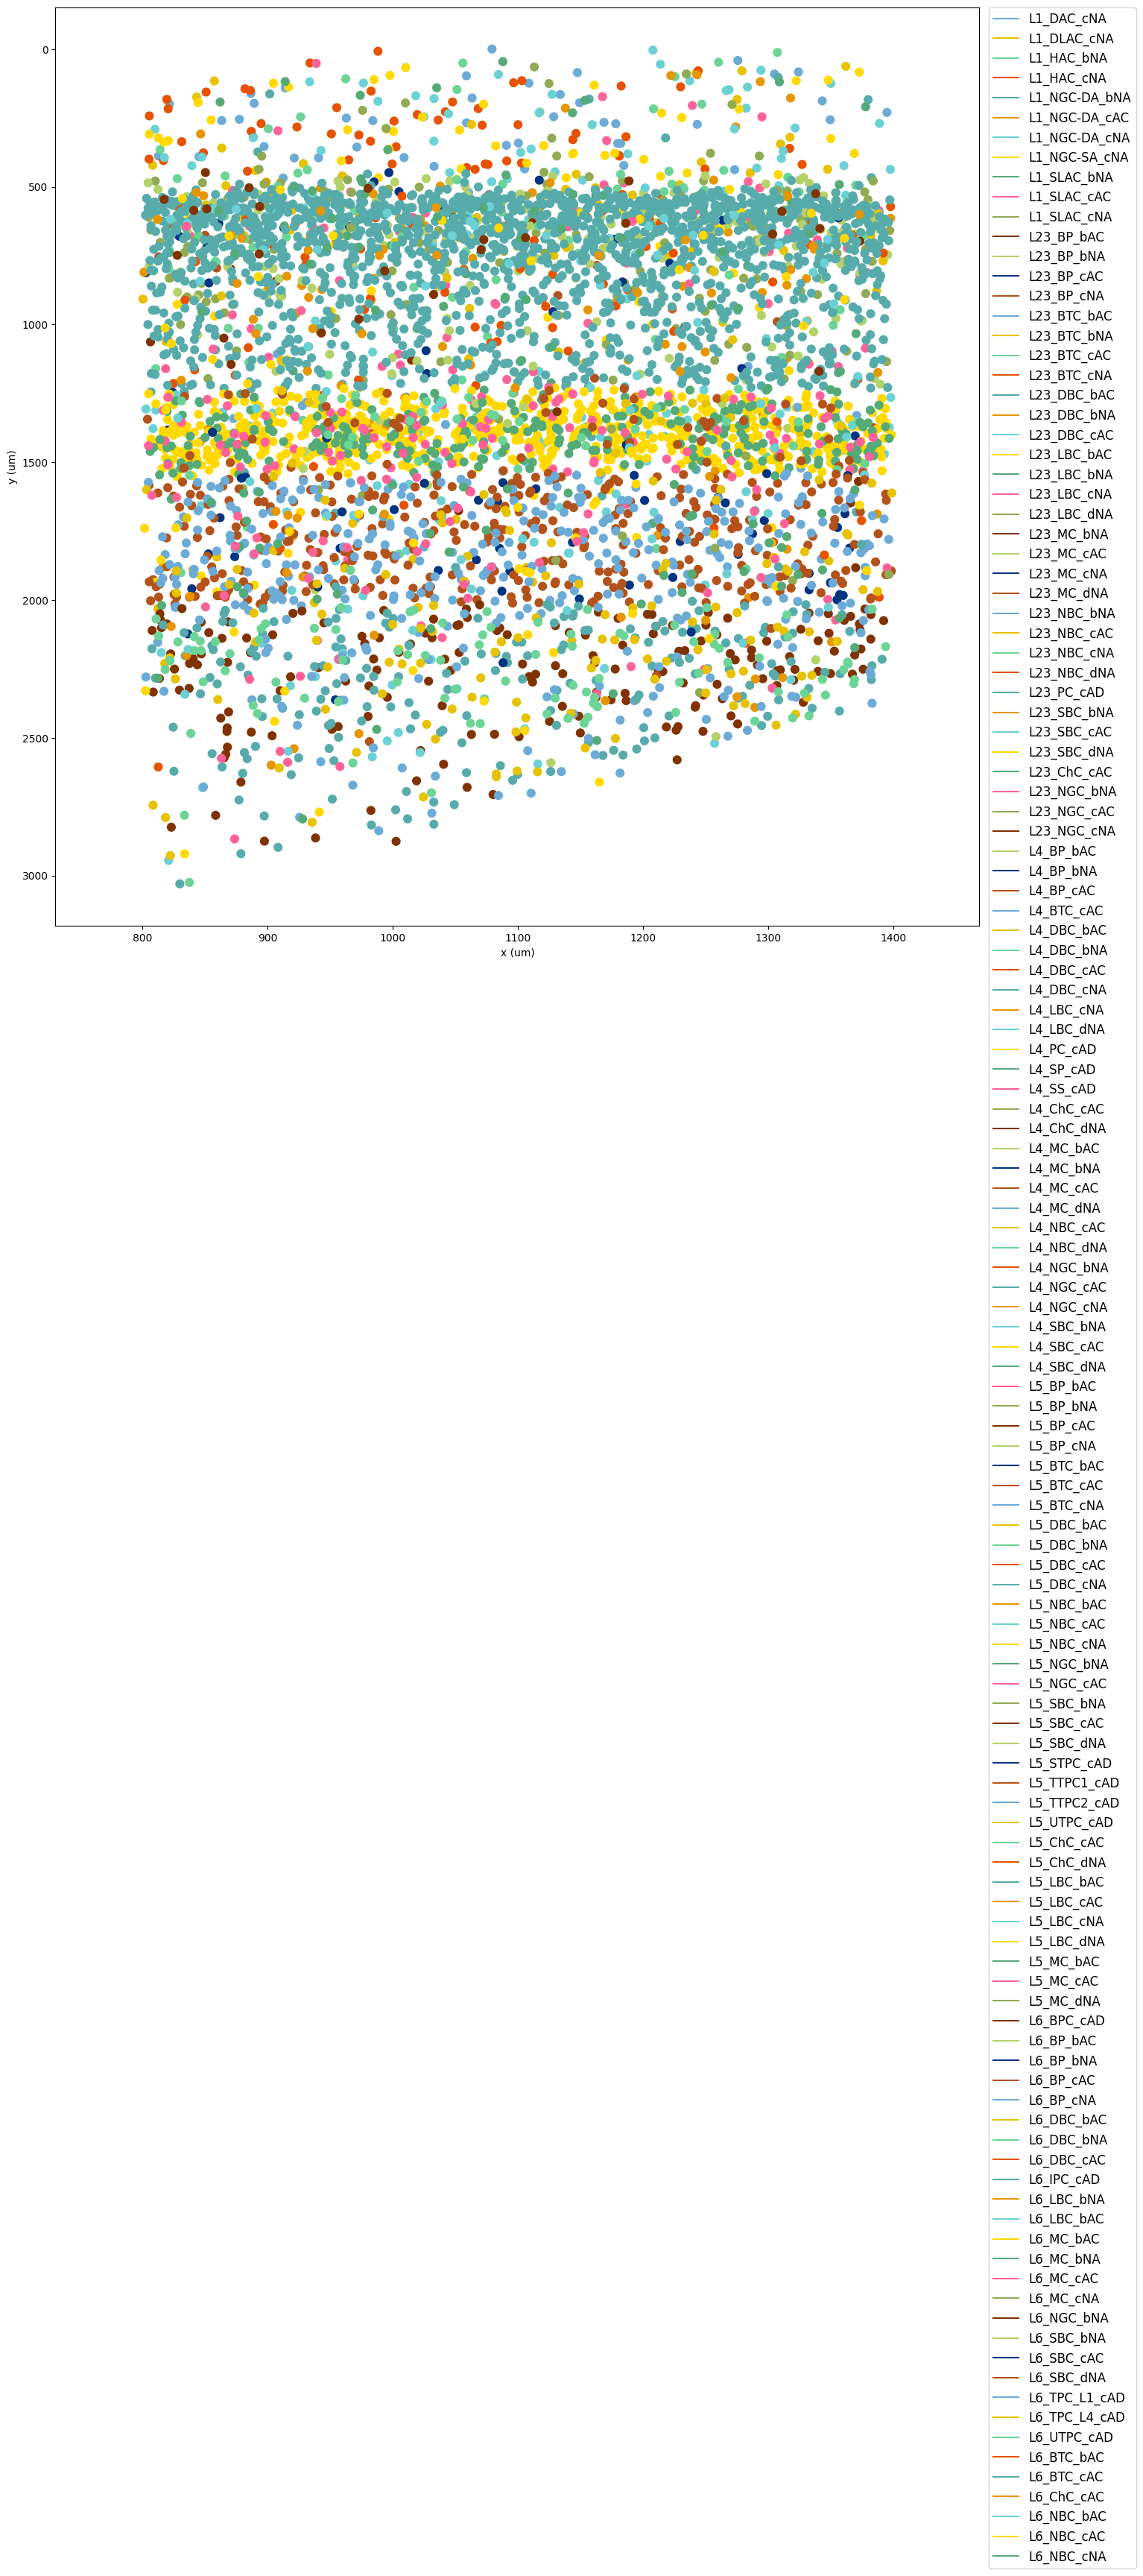

In [71]:
# sim.analysis.plot2Dnet(include=cfg.allpops, view='xy', showConns=True, 
#                                popColors=None, tagsFile=None, figSize=(12, 12), fontSize=8, saveData=None, 
#                                saveFig=False, showFig=True, lineWidth=0.1);
# sim.analysis.plot2Dnet(include=cfg.allpops[0:11] + cfg.Ecells,view='xy', showConns=False, 
#                                popColors=None, tagsFile=None, figSize=(8, 16), fontSize=12, saveData=None, 
#                                saveFig=None, showFig=True, lineWidth=0.1);
sim.analysis.plot2Dnet(include=cfg.allpops,view='xy', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(16, 16), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

Plotting connectivity matrix...


(<Figure size 800x800 with 2 Axes>,
 {'connMatrix': array([[9.2424e+04, 5.3739e+04, 1.8426e+04, 7.1310e+03, 4.2540e+03,
          4.5304e+04, 4.0248e+04, 3.8250e+03, 3.3360e+03, 8.8500e+02,
          2.4660e+03, 2.2710e+03, 3.0390e+03],
         [7.9500e+03, 2.9348e+04, 1.0480e+04, 4.4760e+03, 2.8600e+03,
          2.8960e+04, 2.4730e+04, 2.7520e+03, 2.8560e+03, 9.2400e+02,
          1.5960e+03, 1.7880e+03, 2.0490e+03],
         [1.6830e+03, 7.8810e+03, 3.0920e+03, 1.2630e+03, 9.8800e+02,
          1.0525e+04, 8.7050e+03, 1.1560e+03, 8.7000e+02, 7.5000e+01,
          4.9800e+02, 6.3000e+02, 6.2700e+02],
         [2.9350e+03, 3.2070e+03, 1.5760e+03, 4.5300e+02, 2.8800e+02,
          4.1100e+03, 3.8550e+03, 4.0400e+02, 2.9400e+02, 9.0000e+00,
          1.6500e+02, 1.7400e+02, 2.0100e+02],
         [1.2000e+02, 5.5800e+02, 1.6500e+02, 8.4000e+01, 1.2000e+02,
          1.8400e+03, 1.4100e+03, 1.4800e+02, 3.0900e+02, 1.7100e+02,
          1.3200e+02, 1.0800e+02, 2.1300e+02],
         [1.233

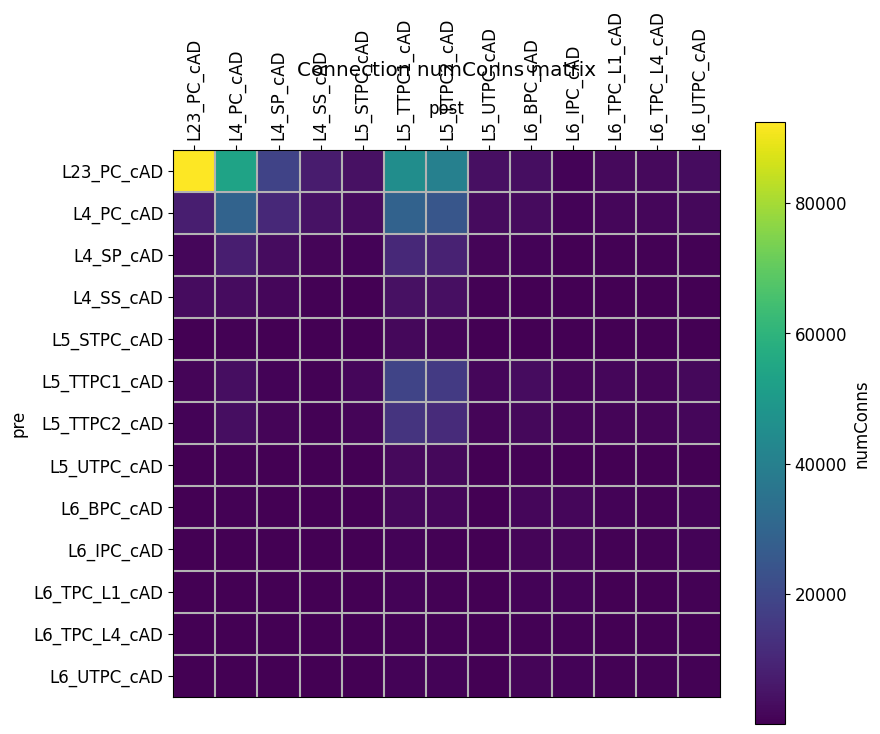

In [72]:
sim.analysis.plotConn(includePre=cfg.Ecells, includePost = cfg.Ecells, feature='numConns', figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=False, showFig=False)

Plotting connectivity matrix...


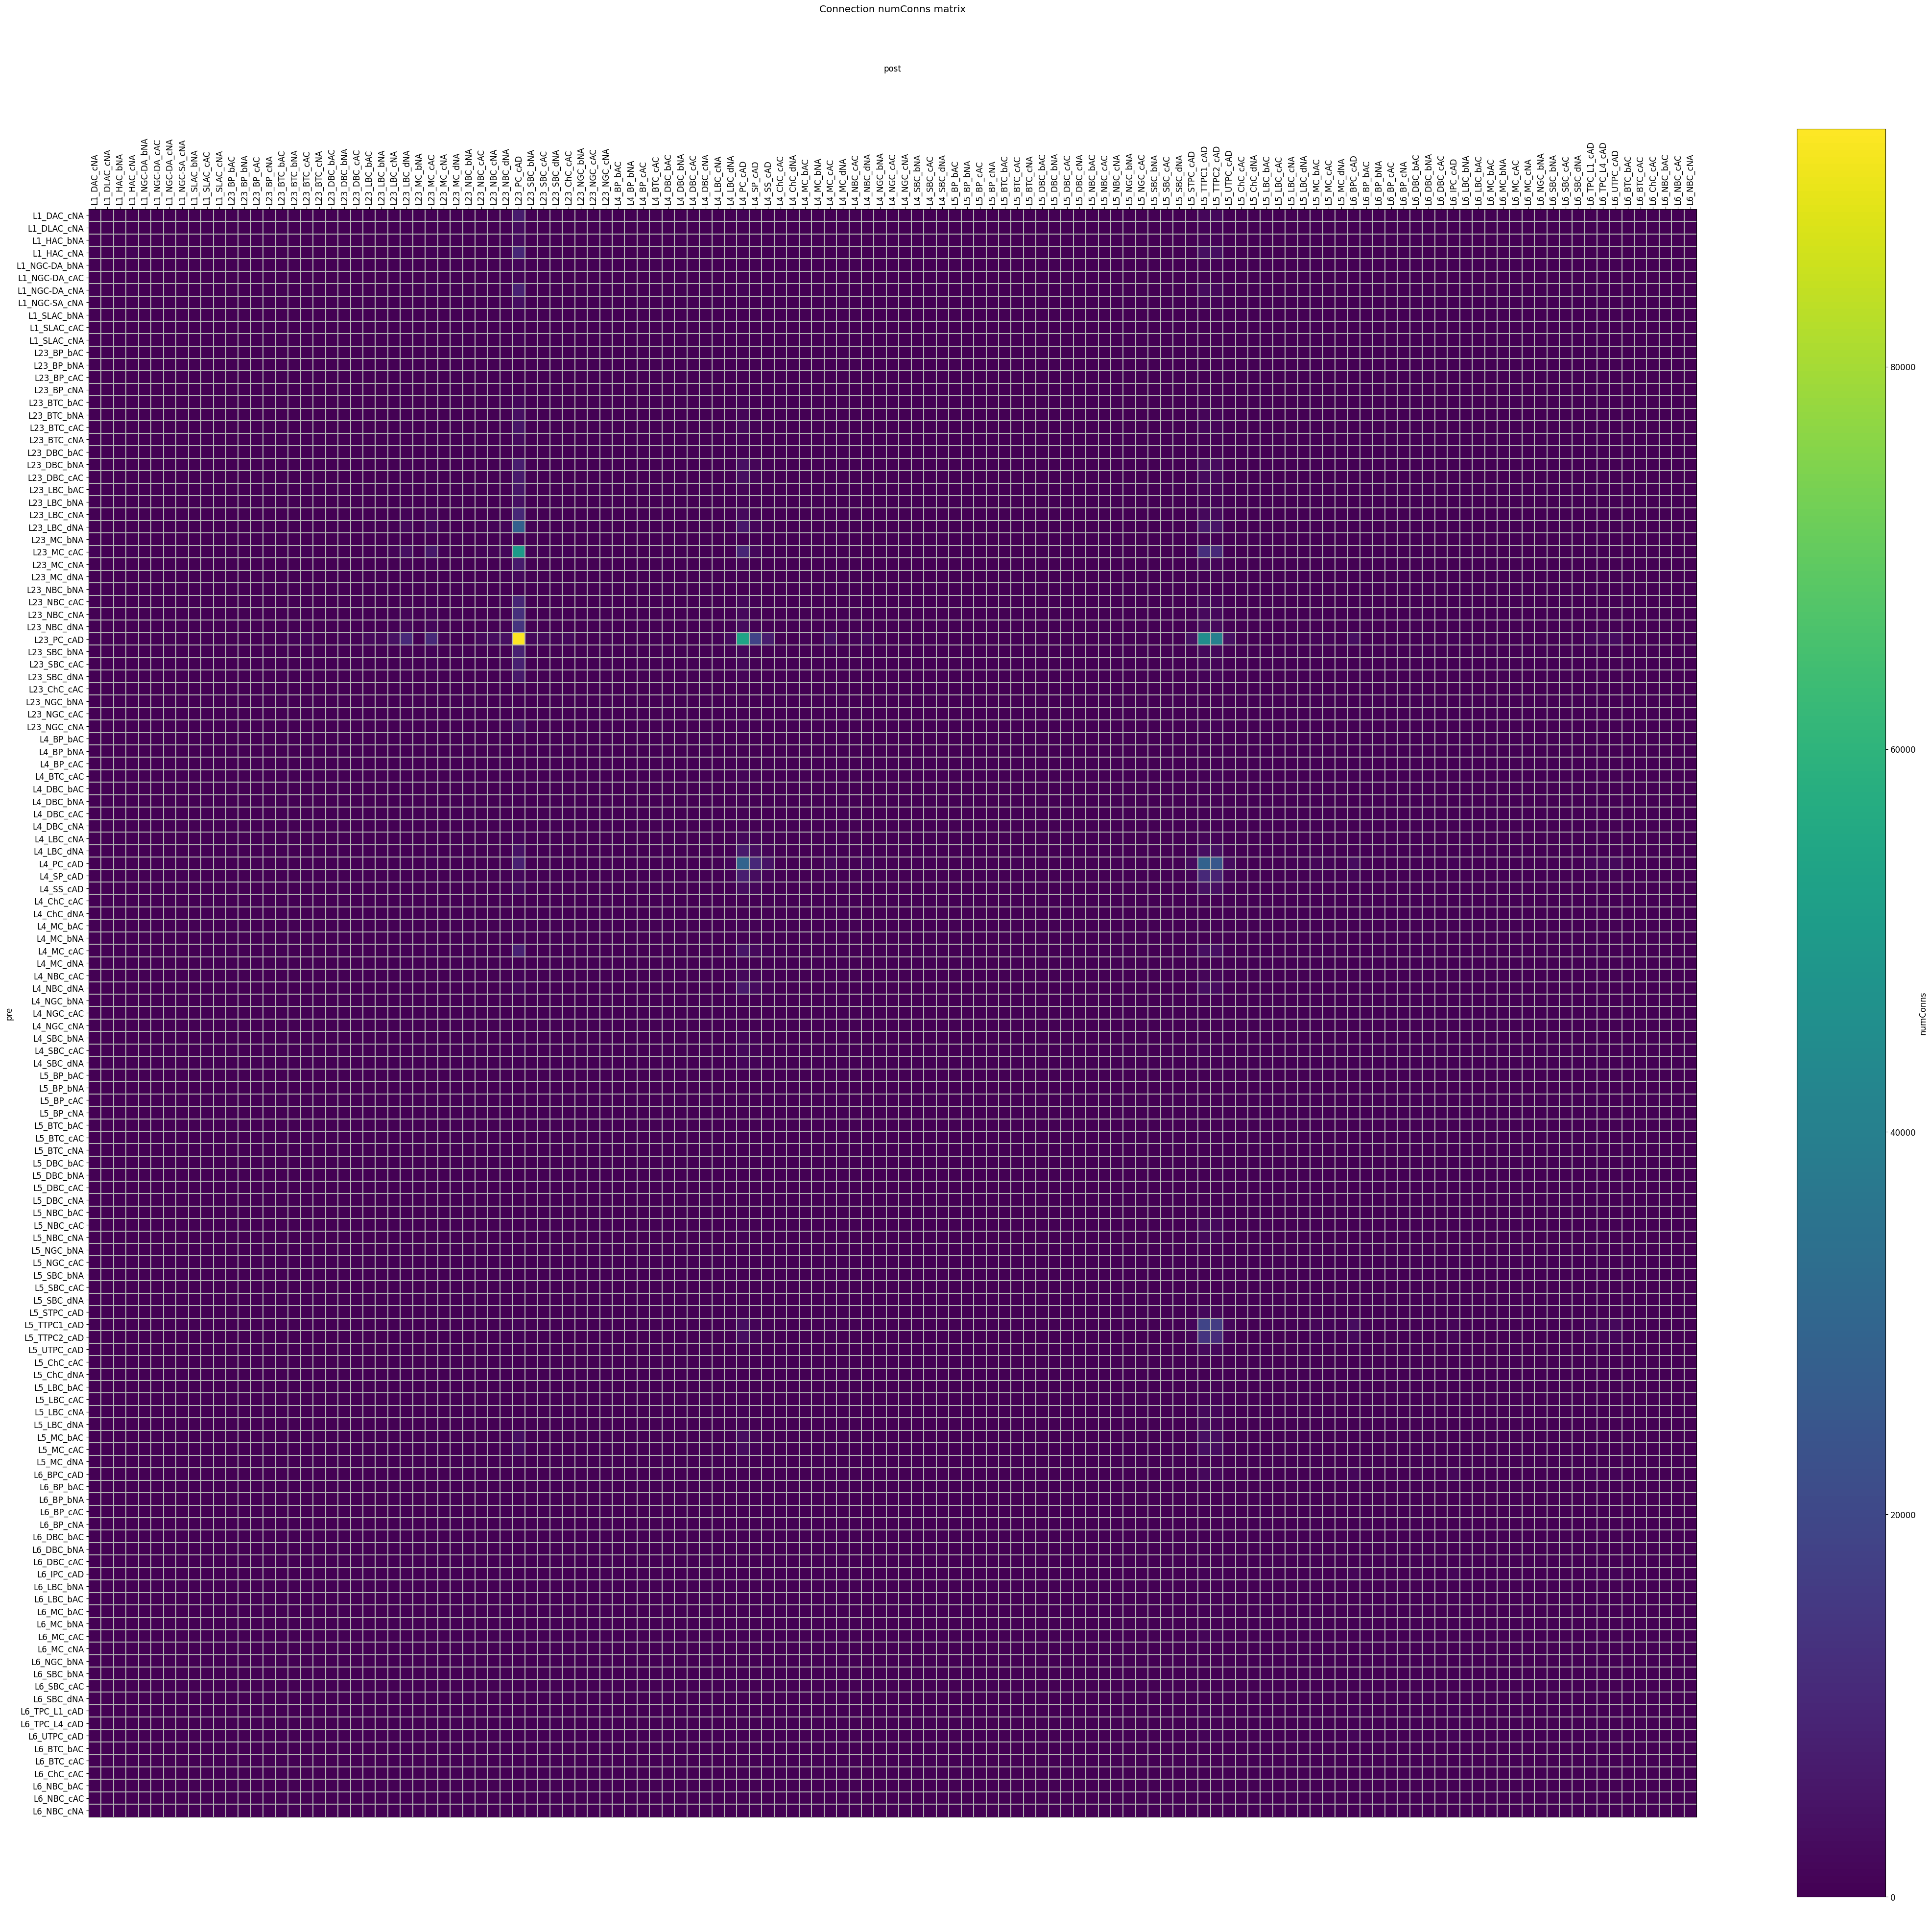

In [73]:
# features = ['numConns','convergence']
test = sim.analysis.plotConn(includePre=cfg.allpops, includePost = cfg.allpops, feature='numConns', figSize=(48, 48), fontSize=12, saveData=None, 
                               saveFig=False, showFig=False);

In [74]:
filenew = [list(vv) for vv in test[1]['connMatrix']]

In [75]:
filenew.append(test[1]['includePre'])

In [76]:
# File name
file_name = "../data/Net_v0/Net_full/matrix_full.json"

# Save the dictionary to a JSON file
with open(file_name, 'w') as f:
  json.dump(filenew, f, indent=4)

In [77]:
connNumber = connData['connNumber']
synperconnNumber = connData['synperconnNumber']

subPopLabels = cfg.S1pops

connNetPyNE = {}
for pre in subPopLabels:
    connNetPyNE[pre] = {}
    for post in subPopLabels:        
        connNetPyNE[pre][post] = 0
               
for i, cellpre in enumerate(cfg.S1cells):
    for j, cellpost in enumerate(cfg.S1cells):
        pre = cfg.popLabel[cellpre] 
        post = cfg.popLabel[cellpost]     

        connBBP = float(connNumber[pre][post])
        if connBBP > 0:
            synperconn = int(synperconnNumber[pre][post]+0.5)     
            connNetPyNE[pre][post] += test[1]['connMatrix'][i][j]/synperconn
            # print(cellpre,cellpost,i,j,test[1]['connMatrix'][i][j]/synperconn)
  
for pre in subPopLabels:
    for post in subPopLabels:  
            connBBP = float(connNumber[pre][post])      
            if connBBP>0 and  pre in Epops and post in Epops: 
                print('\t%s->%s  \t - \t  BBP = %5.1f   \t    NetPyNE = %5.1f  \t   Error = %5.1f' % (pre,post,connBBP,connNetPyNE[pre][post],100*(connNetPyNE[pre][post]-connBBP)/connBBP),'%')


	L23_PC->L23_PC  	 - 	  BBP = 369455.6   	    NetPyNE = 30808.0  	   Error = -91.7 %
	L23_PC->L4_PC  	 - 	  BBP = 268468.6   	    NetPyNE = 17913.0  	   Error = -93.3 %
	L23_PC->L4_SP  	 - 	  BBP = 88977.3   	    NetPyNE = 6142.0  	   Error = -93.1 %
	L23_PC->L4_SS  	 - 	  BBP = 36323.7   	    NetPyNE = 2377.0  	   Error = -93.5 %
	L23_PC->L5_STPC  	 - 	  BBP = 35253.9   	    NetPyNE = 1418.0  	   Error = -96.0 %
	L23_PC->L5_TTPC1  	 - 	  BBP = 276644.3   	    NetPyNE = 11326.0  	   Error = -95.9 %
	L23_PC->L5_TTPC2  	 - 	  BBP = 251113.9   	    NetPyNE = 10062.0  	   Error = -96.0 %
	L23_PC->L5_UTPC  	 - 	  BBP = 32889.3   	    NetPyNE = 1275.0  	   Error = -96.1 %
	L23_PC->L6_BPC  	 - 	  BBP = 76379.1   	    NetPyNE = 1112.0  	   Error = -98.5 %
	L23_PC->L6_IPC  	 - 	  BBP = 17930.9   	    NetPyNE = 295.0  	   Error = -98.4 %
	L23_PC->L6_TPC_L1  	 - 	  BBP = 52891.7   	    NetPyNE = 822.0  	   Error = -98.4 %
	L23_PC->L6_TPC_L4  	 - 	  BBP = 49406.0   	    NetPyNE = 757.0  	   Error 

Plotting 2D representation of network cell locations and connections...


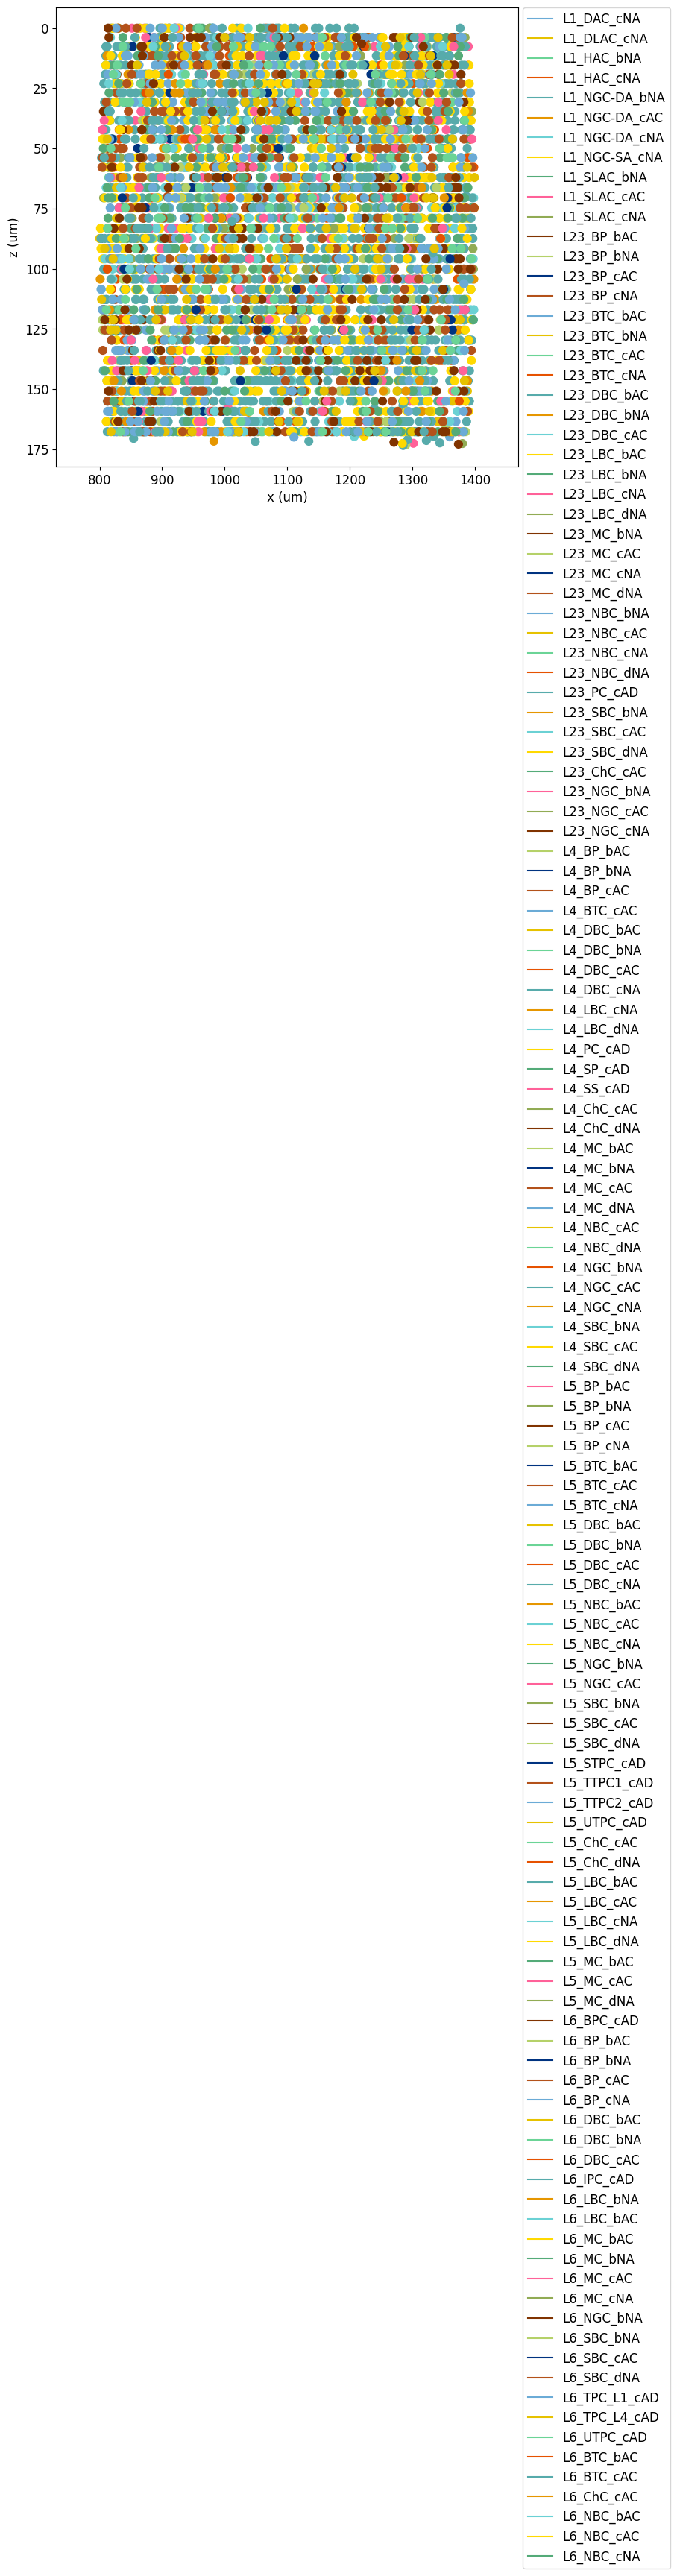

In [78]:
sim.analysis.plot2Dnet(include=cfg.allpops,view='xz', showConns=False, 
                               popColors=None, tagsFile=None, figSize=(8, 8), fontSize=12, saveData=None, 
                               saveFig=None, showFig=True, lineWidth=0.1);

In [79]:
sim.net.cells[-1].stims

[]

In [80]:
sim.net.cells[-1].conns

[{preGid: 4836, sec: 'soma_0', loc: 0.1, synMech: 'S1_II_STP_Det_1', weight: 0.83, delay: 0.48040769054032273, preLoc: 0.5, hObj: NetCon[761829]},
 {preGid: 4836, sec: 'soma_0', loc: 0.30000000000000004, synMech: 'S1_II_STP_Det_1', weight: 0.83, delay: 0.48040769054032273, preLoc: 0.5, hObj: NetCon[761830]},
 {preGid: 4836, sec: 'soma_0', loc: 0.5, synMech: 'S1_II_STP_Det_1', weight: 0.83, delay: 0.48040769054032273, preLoc: 0.5, hObj: NetCon[761831]},
 {preGid: 4836, sec: 'soma_0', loc: 0.7000000000000001, synMech: 'S1_II_STP_Det_1', weight: 0.83, delay: 0.48040769054032273, preLoc: 0.5, hObj: NetCon[761832]},
 {preGid: 4836, sec: 'soma_0', loc: 0.9, synMech: 'S1_II_STP_Det_1', weight: 0.83, delay: 0.48040769054032273, preLoc: 0.5, hObj: NetCon[761833]},
 {preGid: 1319, sec: 'soma_0', loc: 0.1, synMech: 'S1_EI_STP_Det_115', weight: 0.72, delay: 5.217033384990869, preLoc: 0.5, hObj: NetCon[891926]},
 {preGid: 1319, sec: 'soma_0', loc: 0.30000000000000004, synMech: 'S1_EI_STP_Det_115', 